In [38]:
import healpy as h
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
sys.path.append(os.path.abspath('/Users/adityarotti/Documents/Work/core_codes/generate_apodized_mask/'))
from modules.settings import global_mmf_settings as gset
from modules.data_preprocess import preprocess_planck_data as ppd
from modules.masking import gen_masks
from modules.master import binned_master as bm
from astropy.io import fits
from copy import copy,deepcopy
import pymain as gen_apo_mask
%pylab notebook

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
            
result_path="../../results/yy_spec_check/" ; ensure_dir(result_path)
datapath="/Users/adityarotti/Documents/Work/Data/Planck/"

color={}
color["planck"]="k"
color["planck_rc"]="gray"
color["urc"]="blue"
color["rc"]="magenta"

Populating the interactive namespace from numpy and matplotlib


# Initialising the analysis

In [23]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"

figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)

In [24]:
do_dgrade=True ; nsideout=2048
lmax=1500
masklmax=2*nsideout
snr_cutoff=6.
apowidth=15. # arcminutes
gen_ps_mask=False
lf_ps_mask=False

dirname="snr"+str(int(snr_cutoff)) + "_lmax" + str(int(lmax)) + "_mlmax" + str(int(masklmax)) 
dirname=dirname + "_apow" + str(int(apowidth))
if gen_ps_mask:
    if lf_ps_mask:
        dirname=dirname + "_lfpsT"
    else:
        dirname=dirname + "_lfpsF"
else:
    dirname=dirname + "_psmask"
print dirname

figpath=result_path + "/" + dirname + "/figs/"  ; ensure_dir(figpath)
dataout_path=result_path + "/" + dirname + "/data/"   ; ensure_dir(dataout_path)

snr6_lmax1500_mlmax4096_apow15_psmask


# Reading in the MMF3 catalogue

In [4]:
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=6.,cosmo_flag=True)
mmf3=ppd.eval_M500_T500_theta500(mmf3)
median_theta500=median(mmf3["theta500"][mmf3["REDSHIFT"]>0])
mmf3["theta500"][[mmf3["REDSHIFT"]<0]]=median_theta500
shape(mmf3["REDSHIFT"])

/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:26: RuntimeWarning: divide by zero encountered in divide
  return d0(z)/(1.+z)
/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:62: RuntimeWarning: invalid value encountered in multiply
  y=rhs*(500./dA(z))
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(439,)

# Generate point source mask
- The point source mask is generated at the full resolution of NSIDE=2048. Only after multiplying with the galactic mask is the final mask degraded to a lower resolution of NSIDE=512 for the spectral analysis.

In [5]:
if gen_ps_mask:
    if lf_ps_mask:
        gset.mmfset.ps_mask_weights[30.]=1.
        gset.mmfset.ps_mask_weights[44.]=1.
        gset.mmfset.ps_mask_weights[70.]=1.
    else:
        gset.mmfset.ps_mask_weights[30.]=0.
        gset.mmfset.ps_mask_weights[44.]=0.
        gset.mmfset.ps_mask_weights[70.]=0.
    print gset.mmfset.ps_mask_weights
    psmask=ppd.gen_ps_mask(snrthr=5.,ps_cutoff=5.)
else:
    fname=datapath + "/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
    psmask=h.read_map(fname,field=4,verbose=False)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


# Read in the MILCA and NILC y-maps and downgrade to speed up spectral analysis

In [9]:
fname=datapath + "/maps/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits"
gmask=h.read_map(fname,1,verbose=False)
mask=gmask*psmask

fname=datapath + "/maps/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
nilc=h.read_map(fname,0,verbose=False)
nilc_f=h.read_map(fname,1,verbose=False)
nilc_l=h.read_map(fname,2,verbose=False)

fname=datapath + "/maps/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits"
milca=h.read_map(fname,0,verbose=False)
milca_f=h.read_map(fname,1,verbose=False)
milca_l=h.read_map(fname,2,verbose=False)


if do_dgrade:
    mask=h.ud_grade(mask,nsideout) ; mask[mask>=0.2]=1. ; mask[mask<0.2]=0.
    gmask=h.ud_grade(gmask,nsideout) ; gmask[gmask>=0.2]=1. ; gmask[gmask<0.2]=0.
    nilc=h.ud_grade(nilc,nsideout)
    nilc_f=h.ud_grade(nilc_f,nsideout)
    nilc_l=h.ud_grade(nilc_l,nsideout)
    milca=h.ud_grade(milca,nsideout)
    milca_f=h.ud_grade(milca_f,nsideout)
    milca_l=h.ud_grade(milca_l,nsideout)

nside=h.get_nside(mask)
print nside

2048


# Generate the cluster mask. 
- The VIRGO and COMA mask are generated separately as the prescription used to evaluate the
size of the mask for other clusters does not fully mask these clusters, especially VIRGO.


0.43490443627039593 0.42495044072469074 0.01695903142293294


<IPython.core.display.Javascript object>


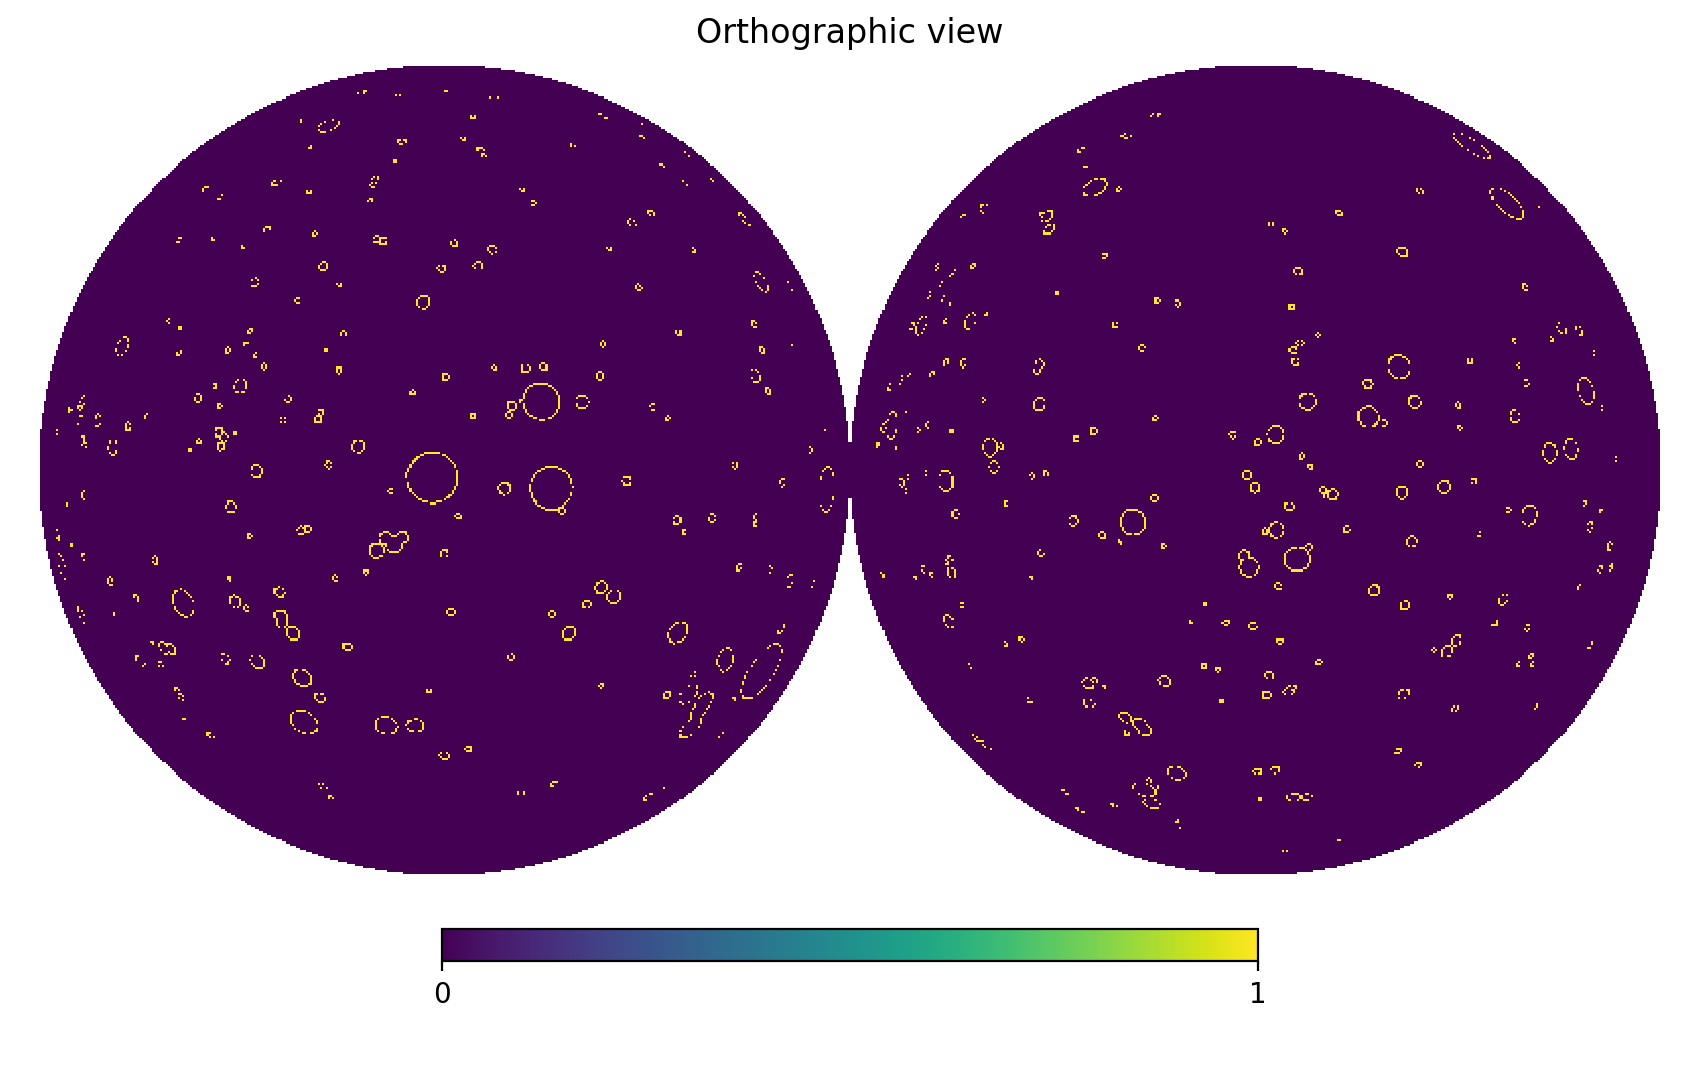

In [79]:
virgo_mask_rc=np.ones_like(mask)
virgo_glon=279.6763 ; virgo_glat=74.4596
pixcs=h.ang2pix(nside,virgo_glon,virgo_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180. + (apowidth/60./2.)*(np.pi/180.)
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
virgo_mask_rc[disc_pix]=0.0

virgo_mask_urc=np.ones_like(mask)
virgo_glon=279.6763 ; virgo_glat=74.4596
pixcs=h.ang2pix(nside,virgo_glon,virgo_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180. - (apowidth/60./2.)*(np.pi/180.)
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
virgo_mask_urc[disc_pix]=0.0

coma_mask_rc=np.ones_like(mask)
coma_glon=058.0791 ; coma_glat=87.9577
pixcs=h.ang2pix(nside,coma_glon,coma_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180. + (apowidth/60./2.)*(np.pi/180.)
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
coma_mask_rc[disc_pix]=0.0


coma_mask_urc=np.ones_like(mask)
coma_glon=058.0791 ; coma_glat=87.9577
pixcs=h.ang2pix(nside,coma_glon,coma_glat,lonlat=True) ; vec=h.pix2vec(nside,pixcs)
radius=3.*np.pi/180. - (apowidth/60./2.)*(np.pi/180.)
disc_pix=h.query_disc(nside,vec,radius=radius,fact=4,inclusive=True)
coma_mask_urc[disc_pix]=0.0

#h.orthview(virgo_mask,rot=(0,90))

clmask=np.ones_like(mask)
clmask_rc=np.ones_like(mask)
clmask_urc=np.ones_like(mask)
pixcs=h.ang2pix(nside,mmf3["GLON"],mmf3["GLAT"],lonlat=True)
radius_rc=5.*(mmf3["theta500"]/60.)*np.pi/180. + (apowidth/60./2.)*(np.pi/180.)
radius_urc=5.*(mmf3["theta500"]/60.)*np.pi/180. - (apowidth/60./2.)*(np.pi/180.)
for i,pix in enumerate(pixcs):
    vec=h.pix2vec(nside,pix)
    disc_pix=h.query_disc(nside,vec,radius=radius_rc[i],fact=4,inclusive=True)
    clmask_rc[disc_pix]=0.0
    disc_pix=h.query_disc(nside,vec,radius=radius_urc[i],fact=4,inclusive=True)
    clmask_urc[disc_pix]=0.0
    
clmask_rc=(1.-clmask_rc*virgo_mask_rc*coma_mask_rc)
clmask_urc=(clmask_urc*virgo_mask_urc*coma_mask_urc)
mask_rc=clmask_rc*mask
mask_urc=clmask_urc*mask

fsky_tot=sum(mask)/size(mask)
fsky_diff=sum(mask*clmask_urc)/size(mask)
fsky_res=sum(mask*clmask_rc)/size(mask)
print fsky_tot,fsky_diff,fsky_res

h.orthview(clmask_rc-(1-clmask_urc),rot=(0,90))

<IPython.core.display.Javascript object>


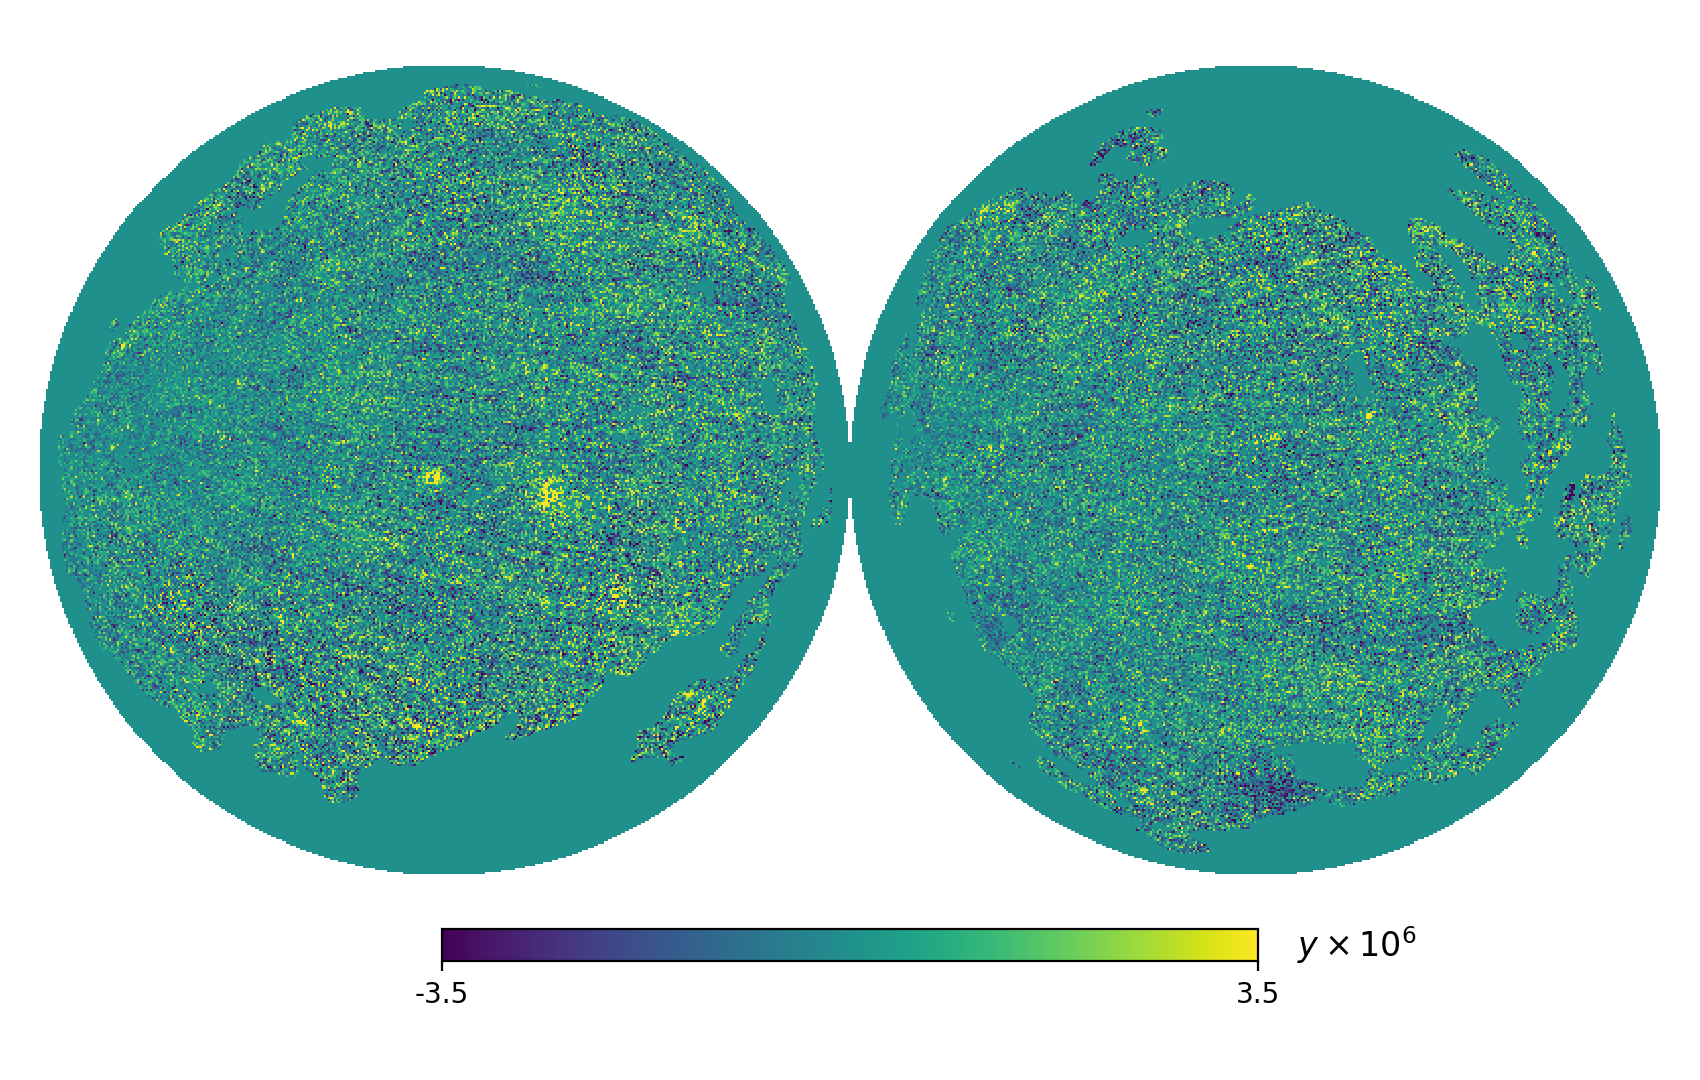

<IPython.core.display.Javascript object>


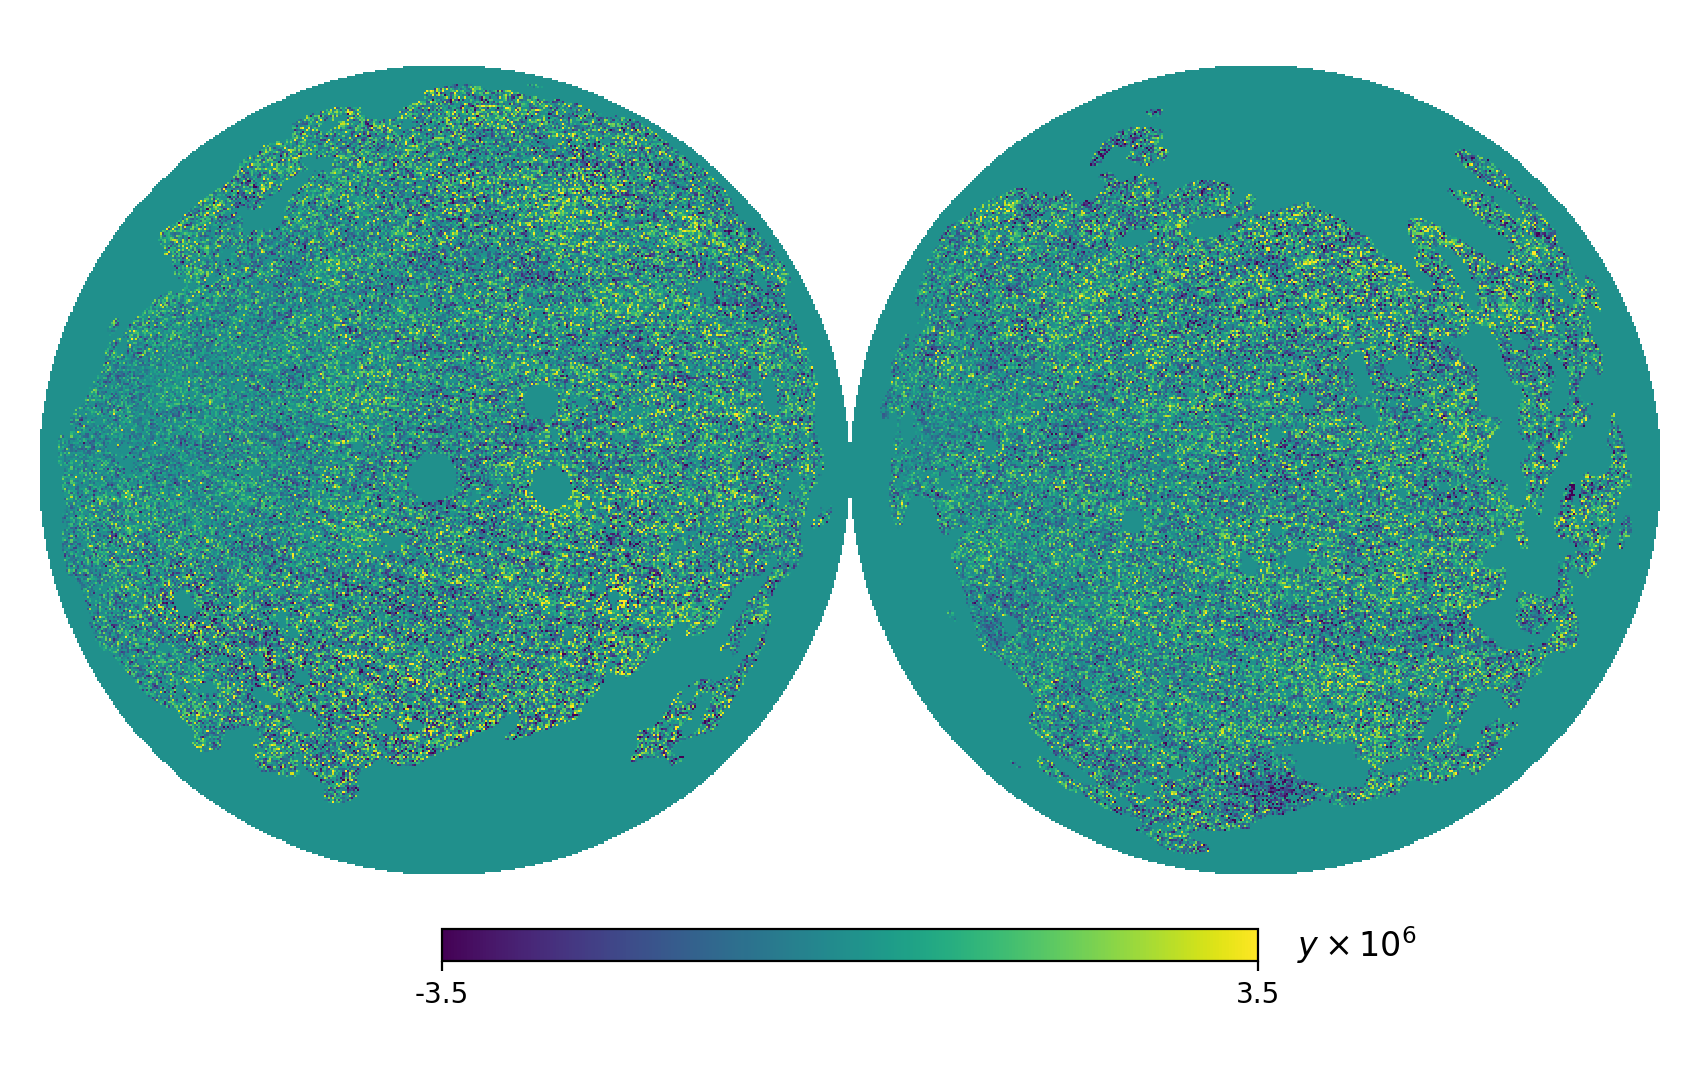

<IPython.core.display.Javascript object>


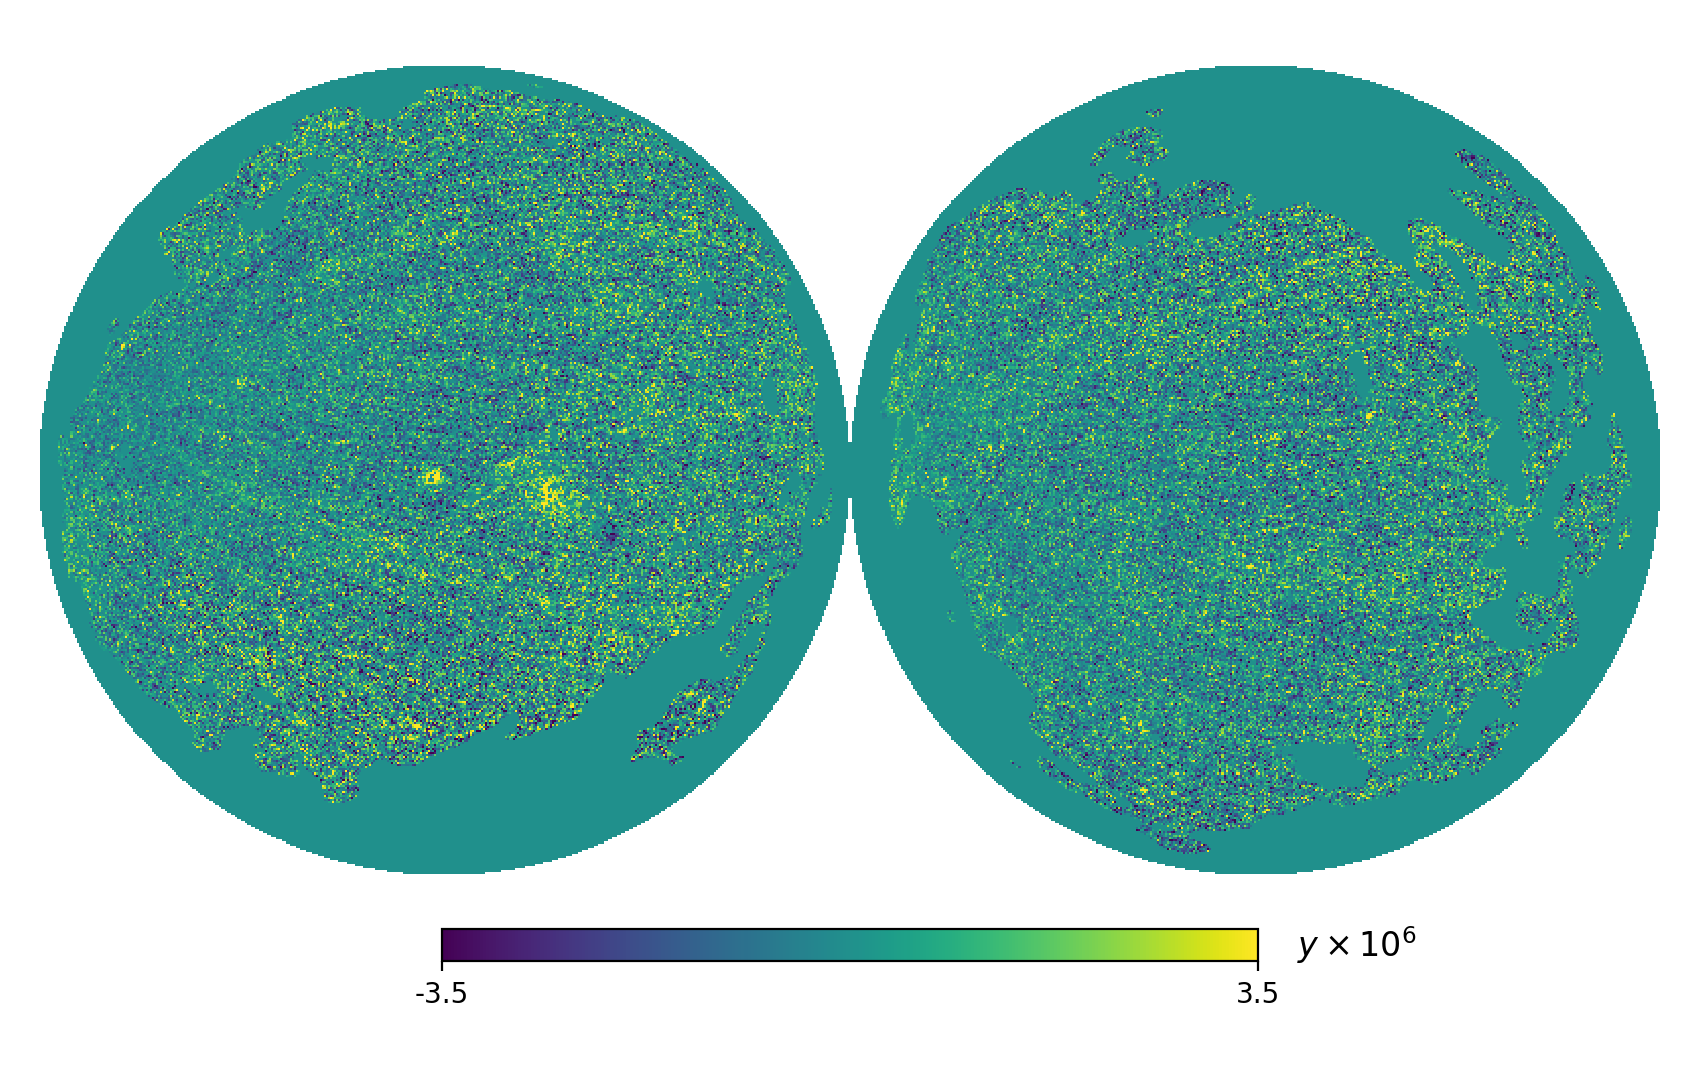

<IPython.core.display.Javascript object>


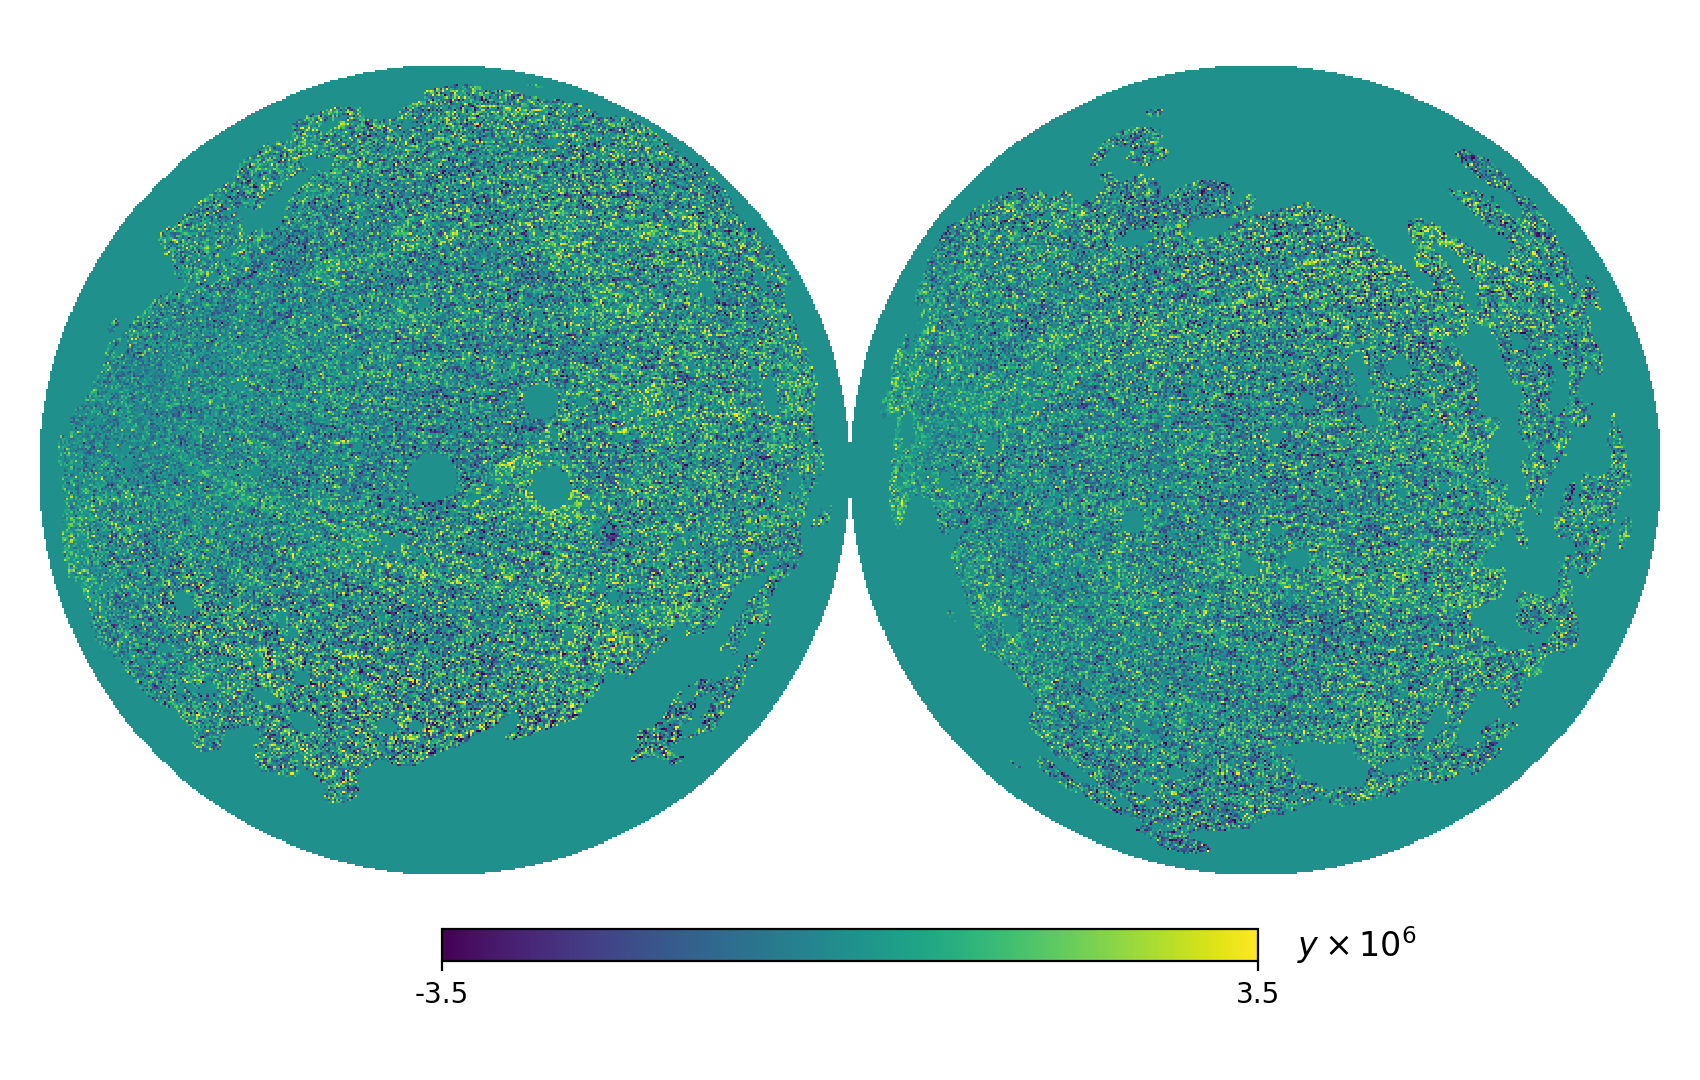

In [80]:
h.orthview(nilc*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(nilc*mask_urc*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "nilc_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*mask*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_before_clmask.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(milca*mask_urc*1e6,min=-3.5,max=3.5,rot=(0,90),title="")
text(1.1,-1.2,r"$y \times 10^6$",fontsize=12)
figname=figpath + "milca_after_clmask.pdf"
savefig(figname,bbox_inches="tight")

## Generate apodized masks

In [81]:
gal_ps_mask=np.copy(mask)
gal_ps_cl_mask=np.copy(mask_rc)
gal_ps_ccl_mask=np.copy(mask_urc)

if apowidth>0.:
    nside=h.get_nside(mask) ; npixtot=h.nside2npix(nside)
    gal_ps_mask=gen_apo_mask.gen_apodized_mask(gal_ps_mask,nside,1,0.,0.,apowidth,npixtot)
    gal_ps_cl_mask=gen_apo_mask.gen_apodized_mask(gal_ps_cl_mask,nside,1,0.,0.,apowidth,npixtot)
    gal_ps_ccl_mask=gen_apo_mask.gen_apodized_mask(gal_ps_ccl_mask,nside,1,0.,0.,apowidth,npixtot)

<IPython.core.display.Javascript object>


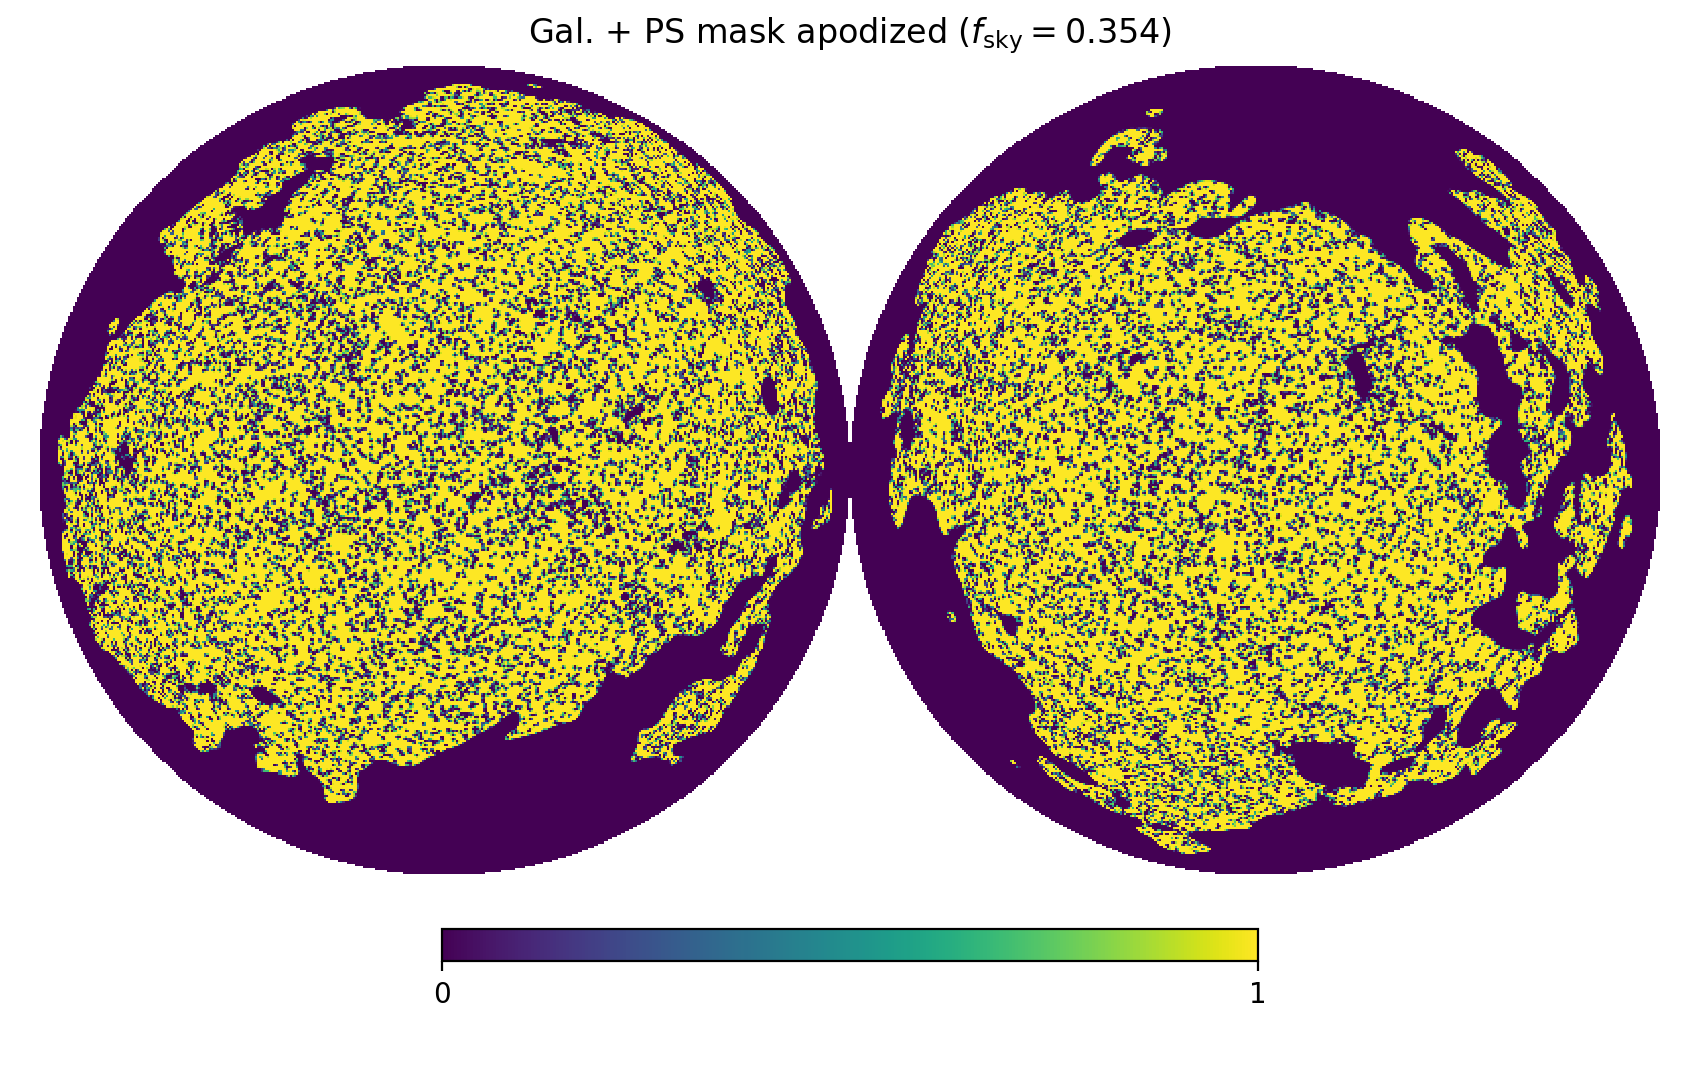

<IPython.core.display.Javascript object>


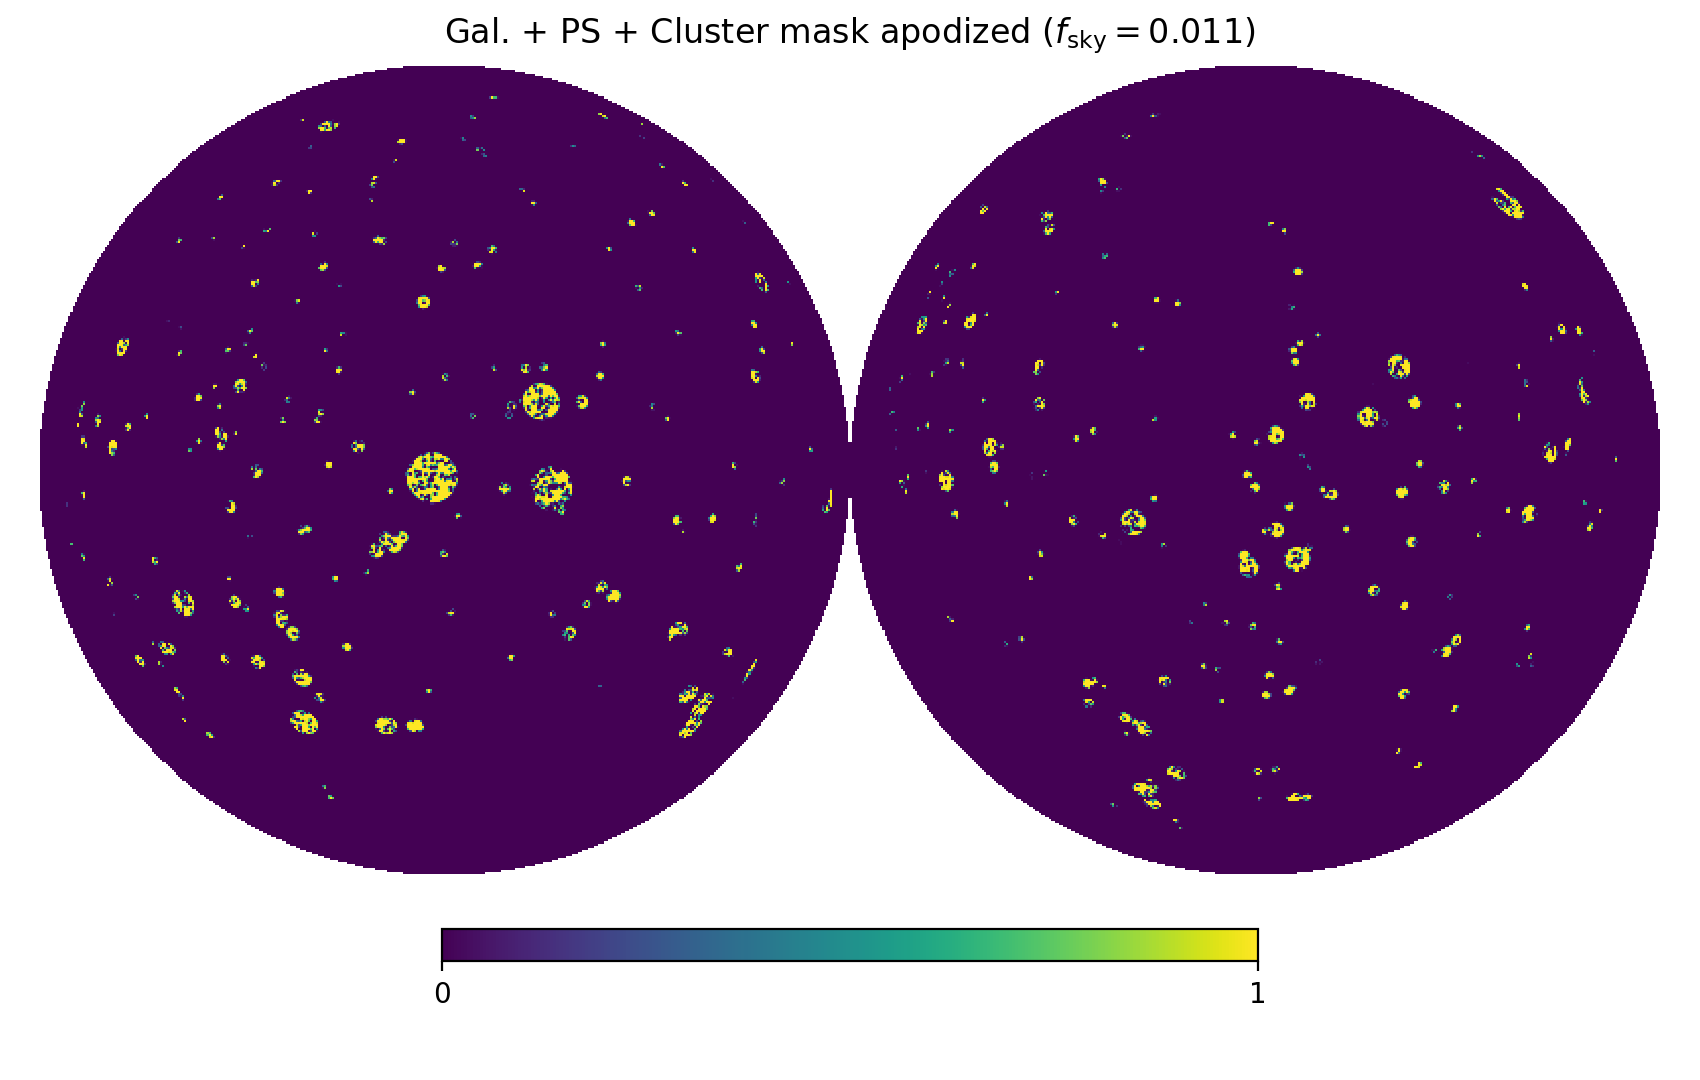

<IPython.core.display.Javascript object>


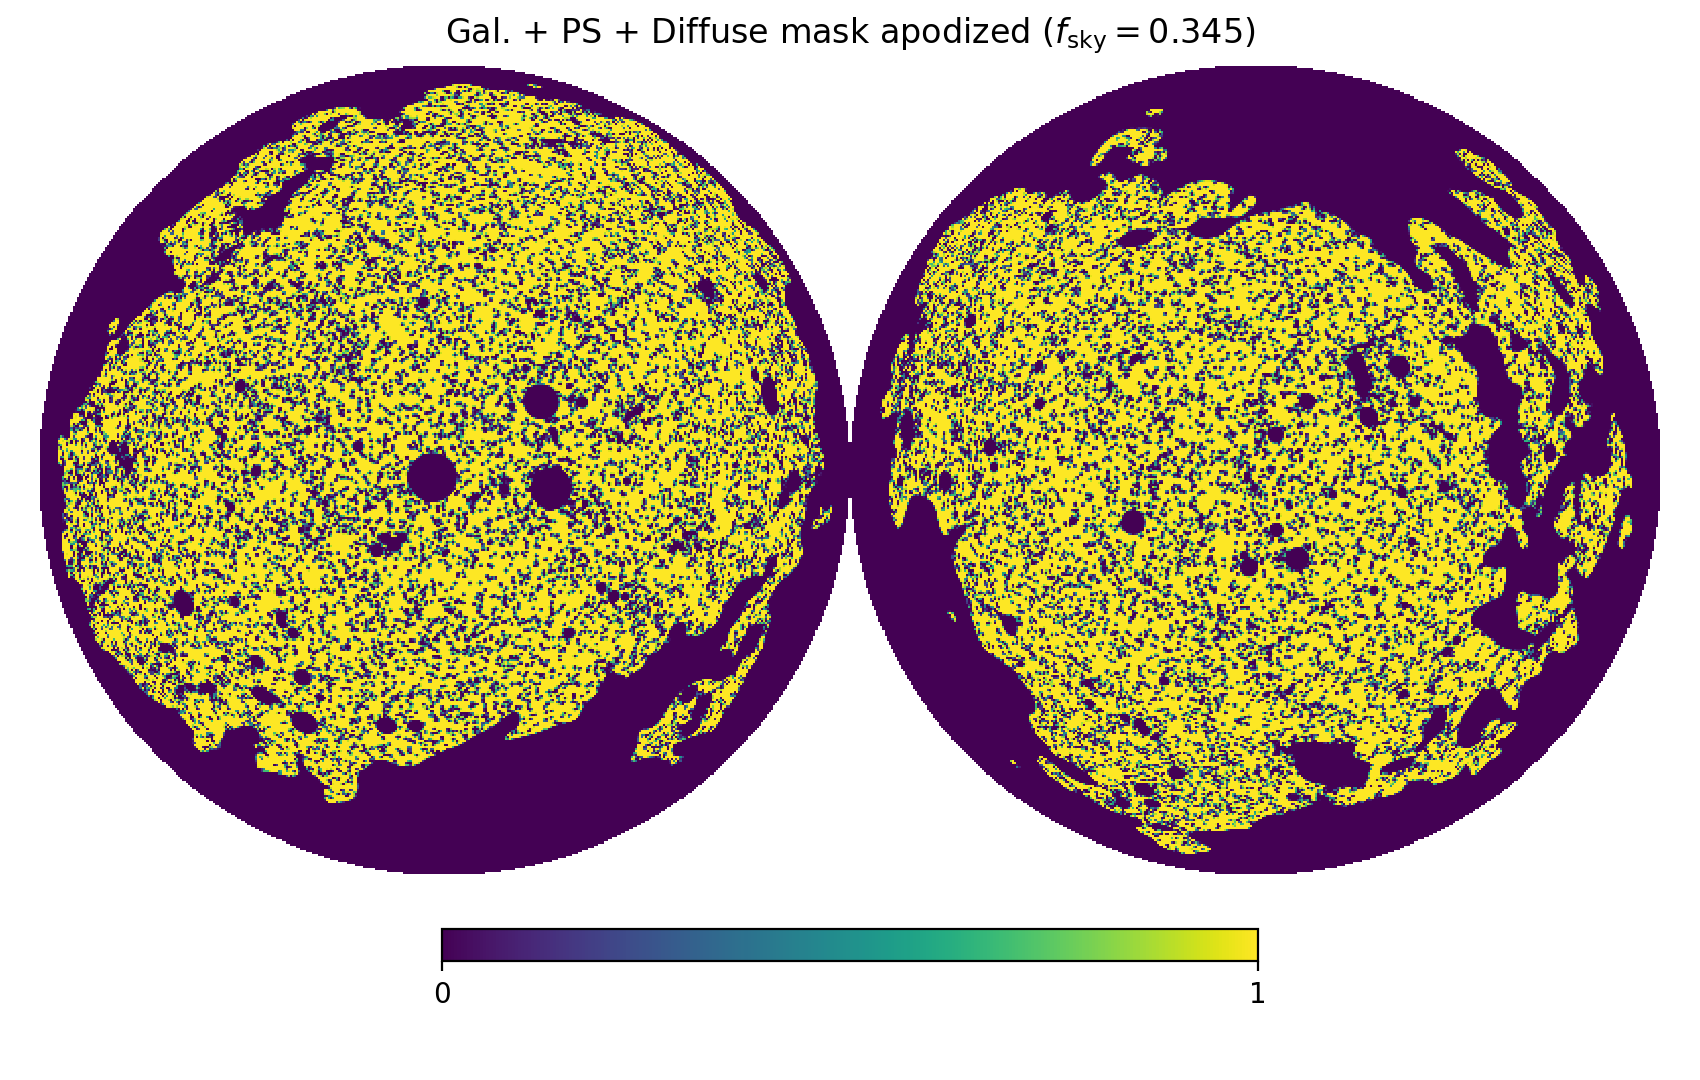

In [82]:
fsky=sum(gal_ps_mask)/size(gal_ps_mask)
h.orthview(gal_ps_mask,rot=(0,90),title=r"Gal. + PS mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_cl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_cl_mask,rot=(0,90),title=r"Gal. + PS + Cluster mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_cl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gal_ps_ccl_mask)/size(gal_ps_mask)
h.orthview(gal_ps_ccl_mask,rot=(0,90),title=r"Gal. + PS + Diffuse mask apodized $(f_{\rm sky}=" + str(round(fsky,3)) + ")$")
figname=figpath + "gal_ps_ccl_mask_apo.pdf"
savefig(figname,bbox_inches="tight")

# Histogram 

<IPython.core.display.Javascript object>


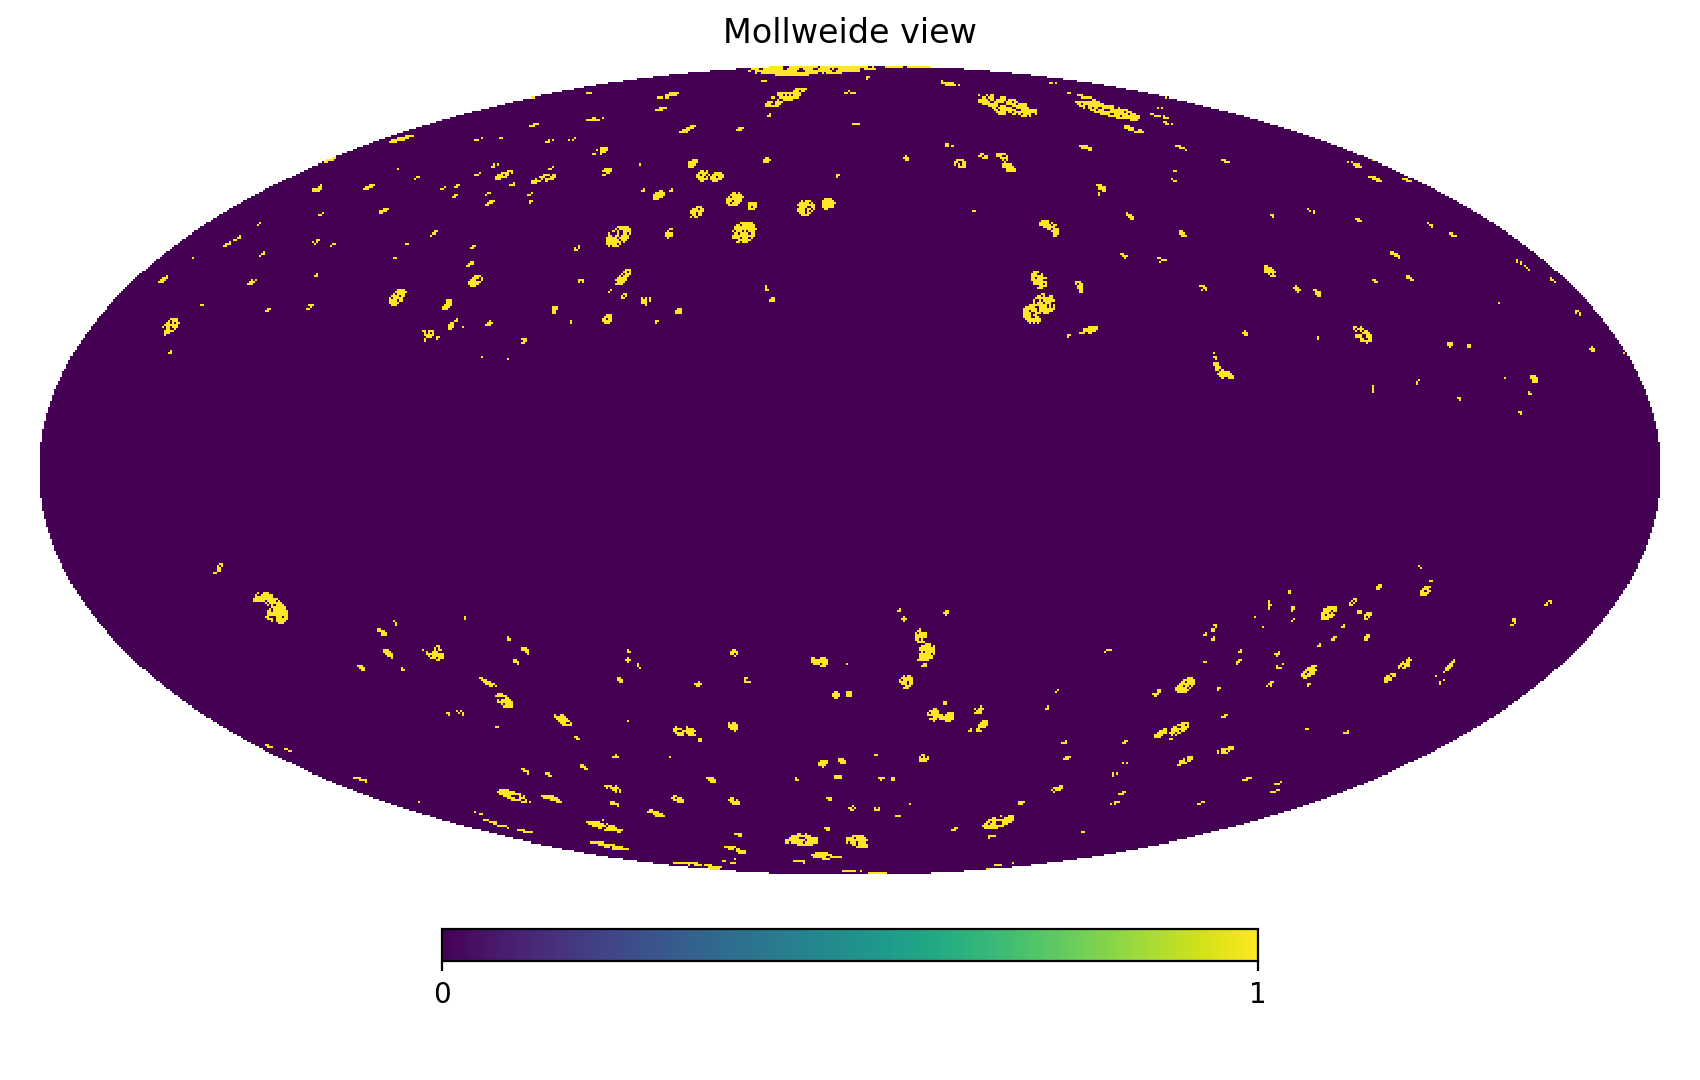

In [86]:
h.mollview(mask_rc)

<IPython.core.display.Javascript object>


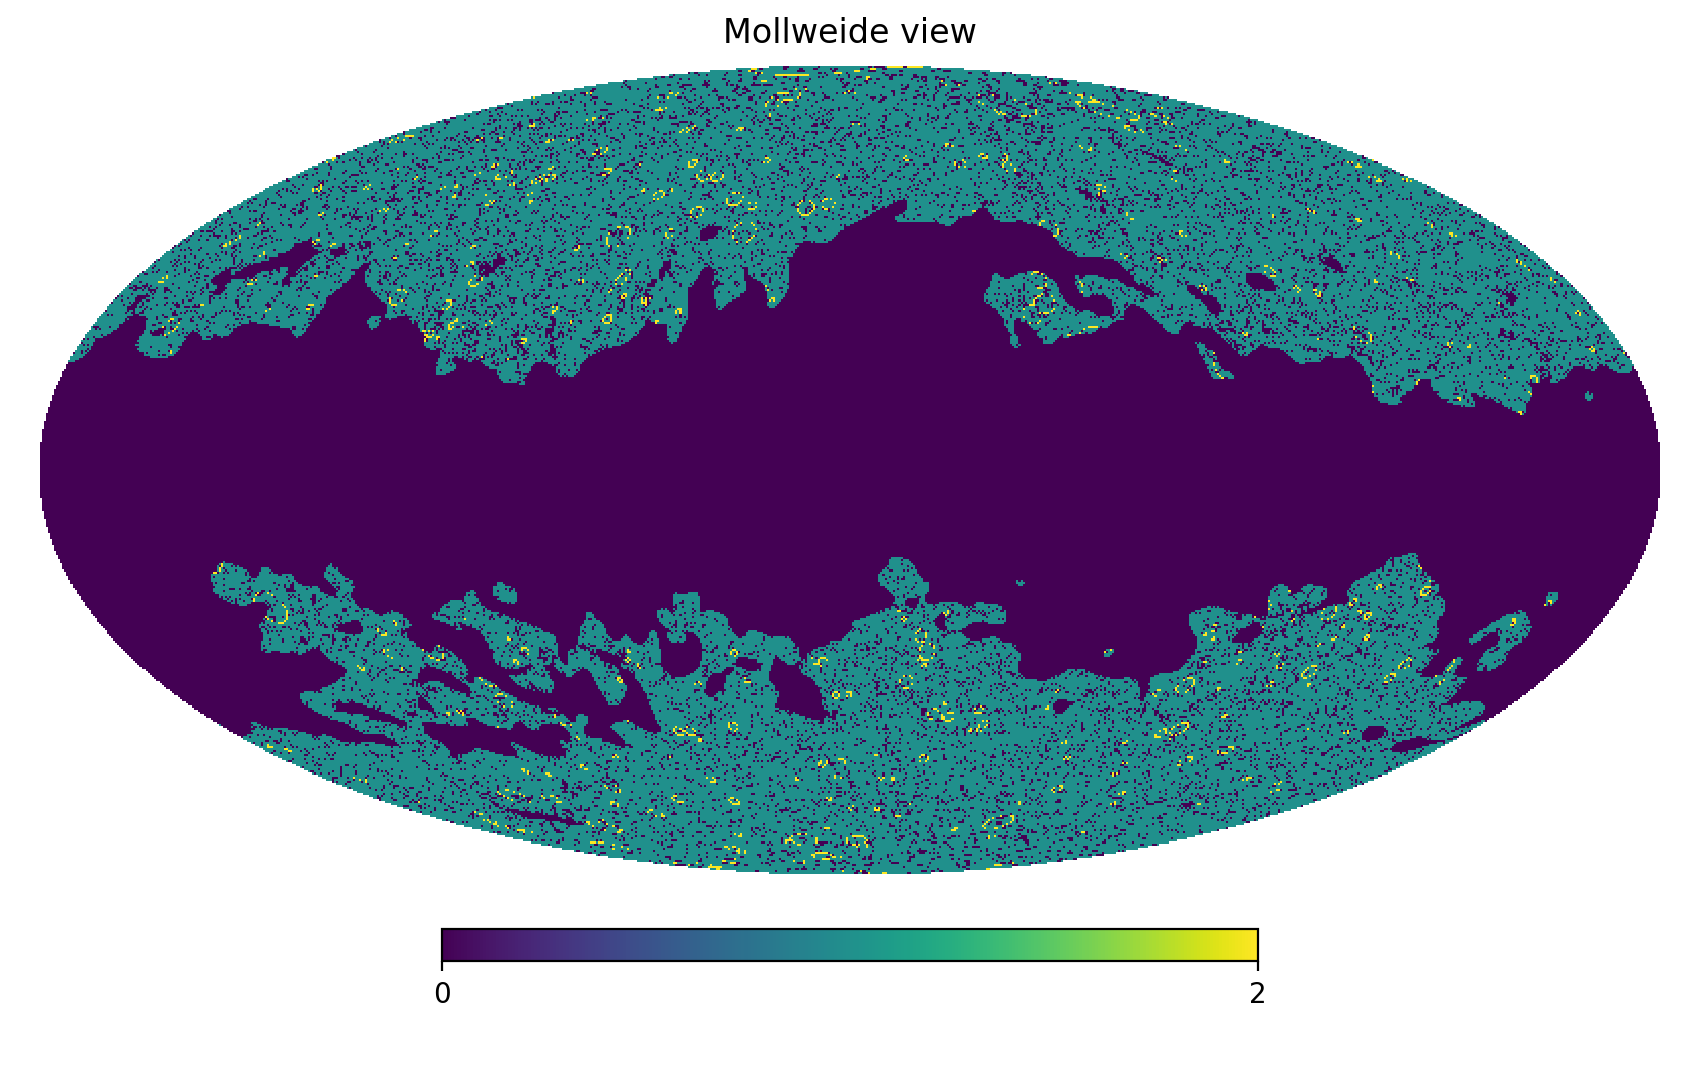

In [88]:
h.mollview(mask_rc+mask_urc)

<IPython.core.display.Javascript object>


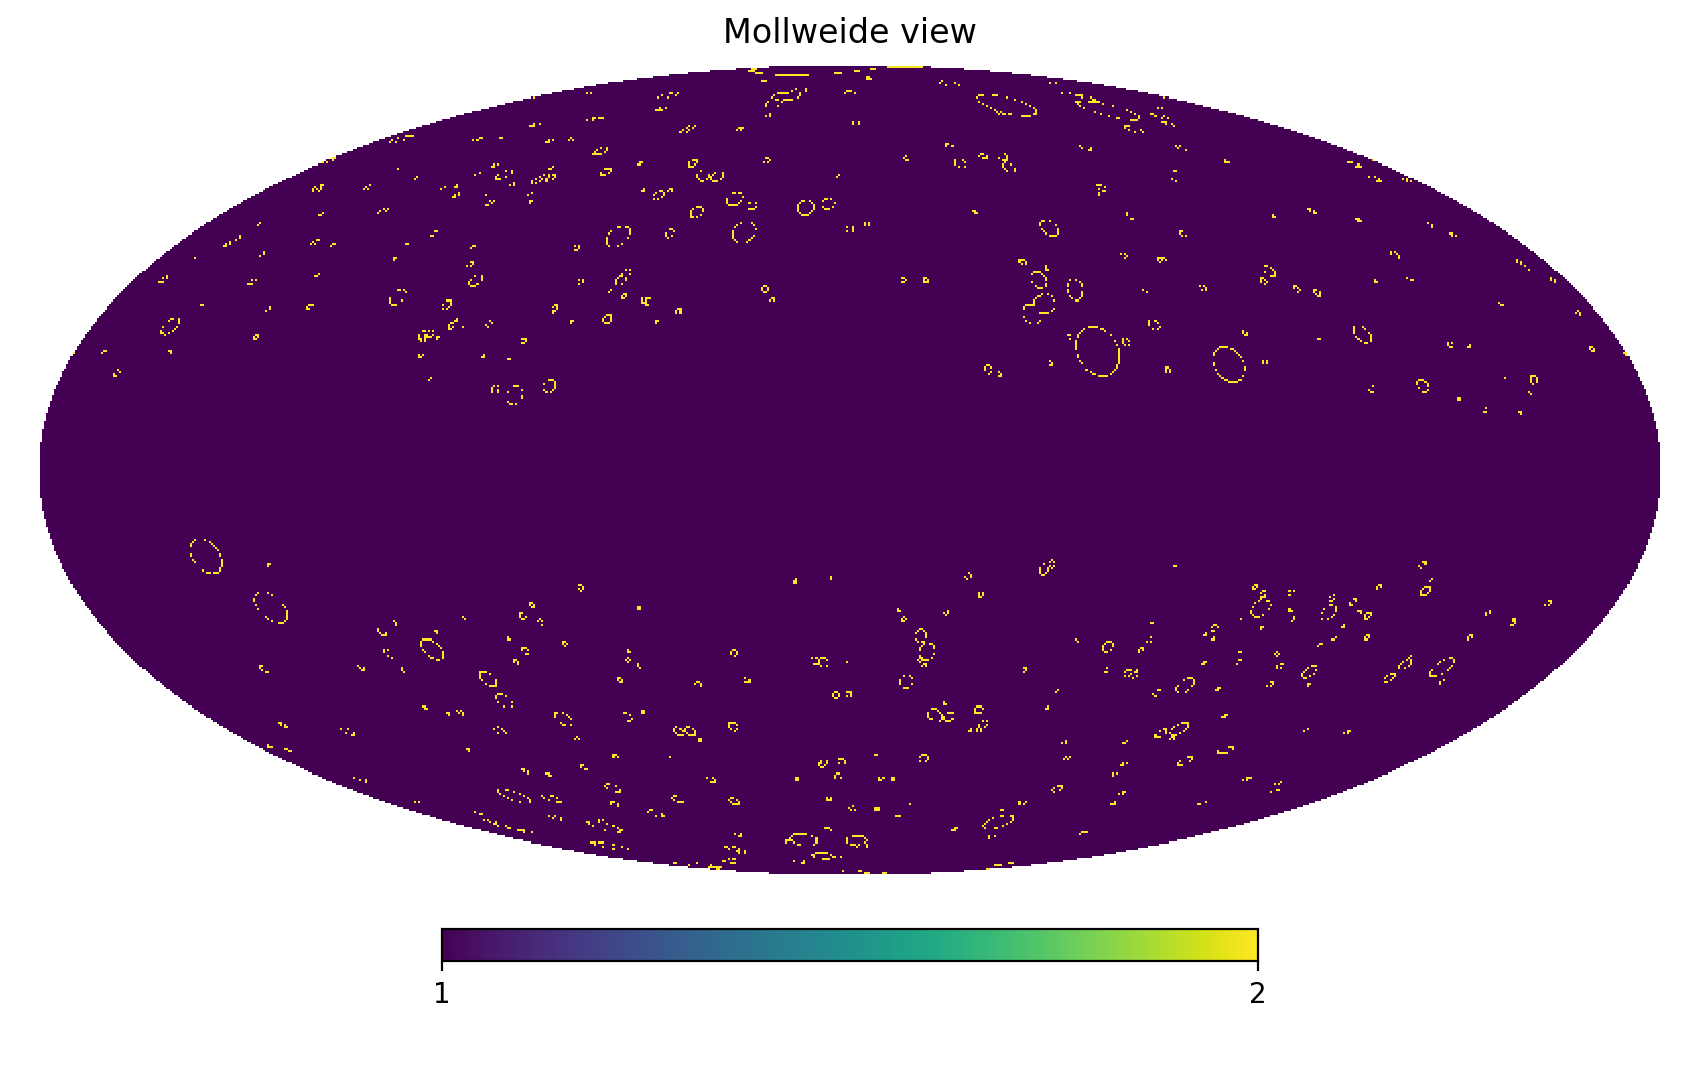

In [100]:
h.mollview(clmask_rc+clmask_urc)

<IPython.core.display.Javascript object>


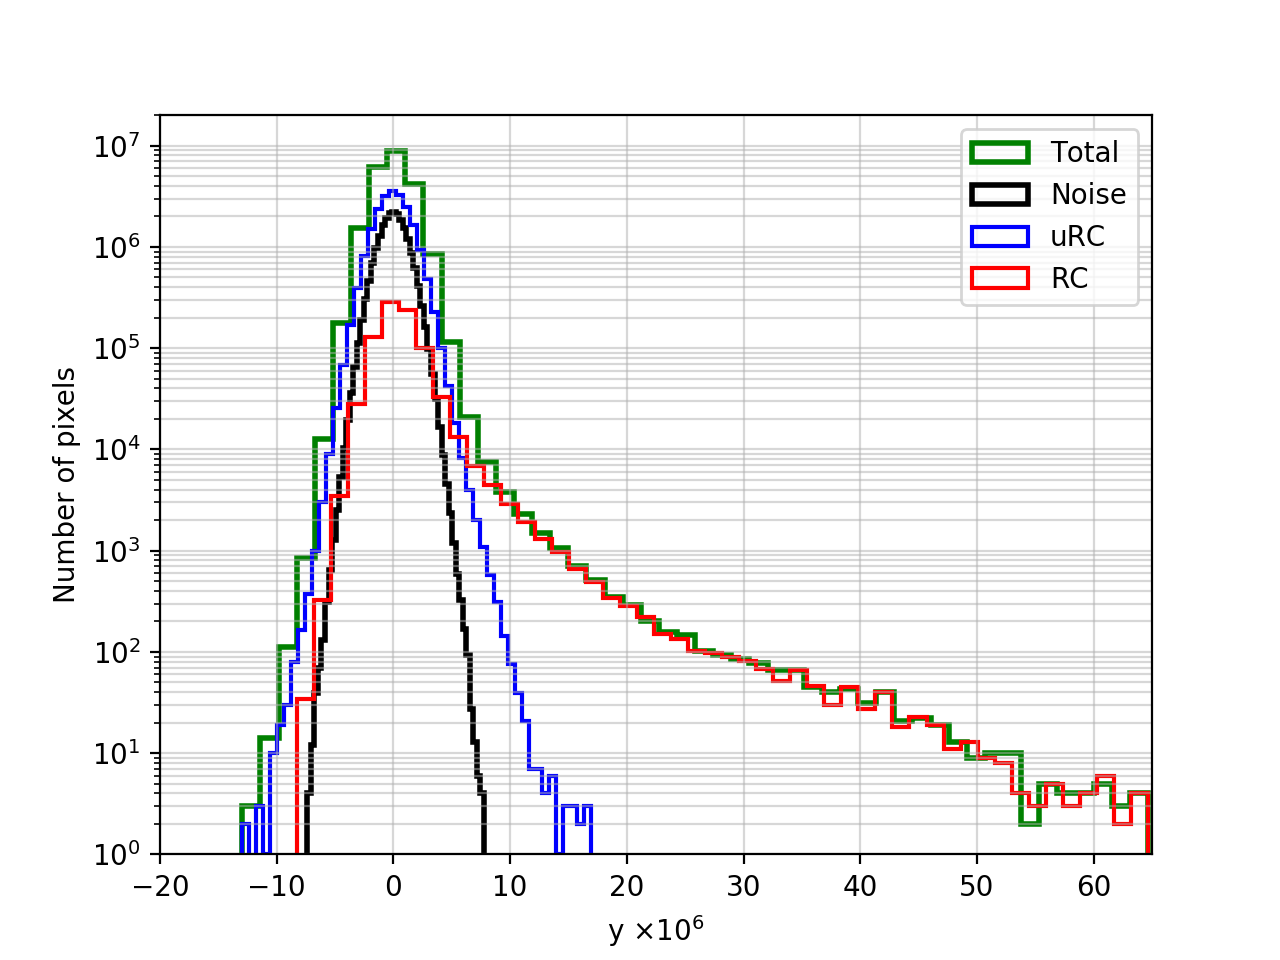

In [98]:
nbins=50
figure()
a,b,c=hist(nilc[mask!=0]*1e6,histtype="step",bins=nbins,normed=False,label="Total",lw=2,color="g")
a,b,c=hist(((nilc_f-nilc_l)/2.)[mask_urc!=0]*1e6,histtype="step",bins=nbins,normed=False,label="Noise",lw=2,color="k")
a,b,c=hist(nilc[mask_urc!=0]*1e6,histtype="step",bins=nbins,normed=False,label="uRC",lw=1.5,color="b")
a,b,c=hist(nilc[mask_rc!=0]*1e6,histtype="step",bins=nbins,normed=False,label="RC",lw=1.5,color="r")
semilogy()
legend(loc=0)
ylim(1,2e7)
xlim(-20,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_nilc_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


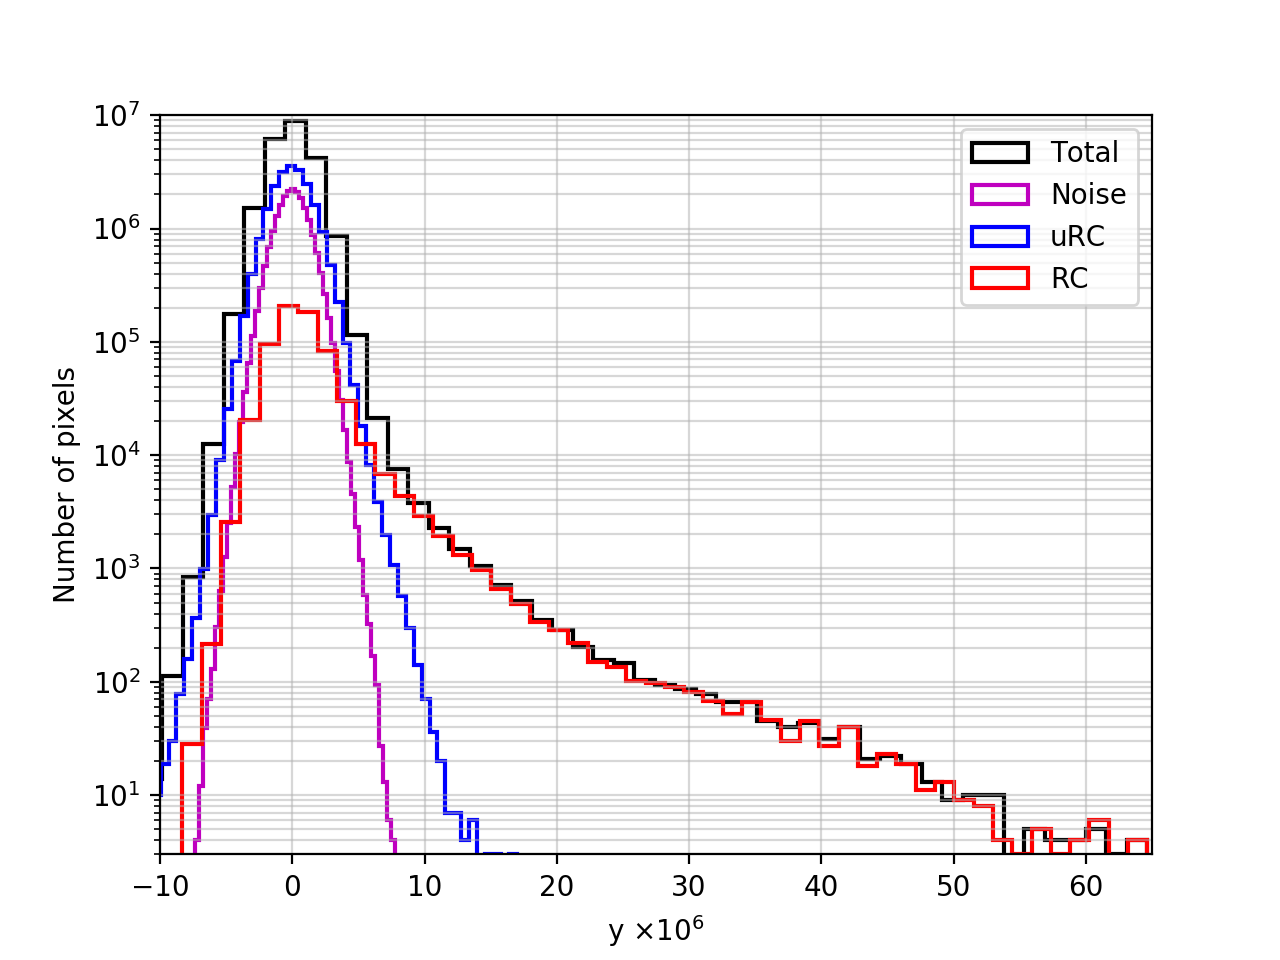

<IPython.core.display.Javascript object>


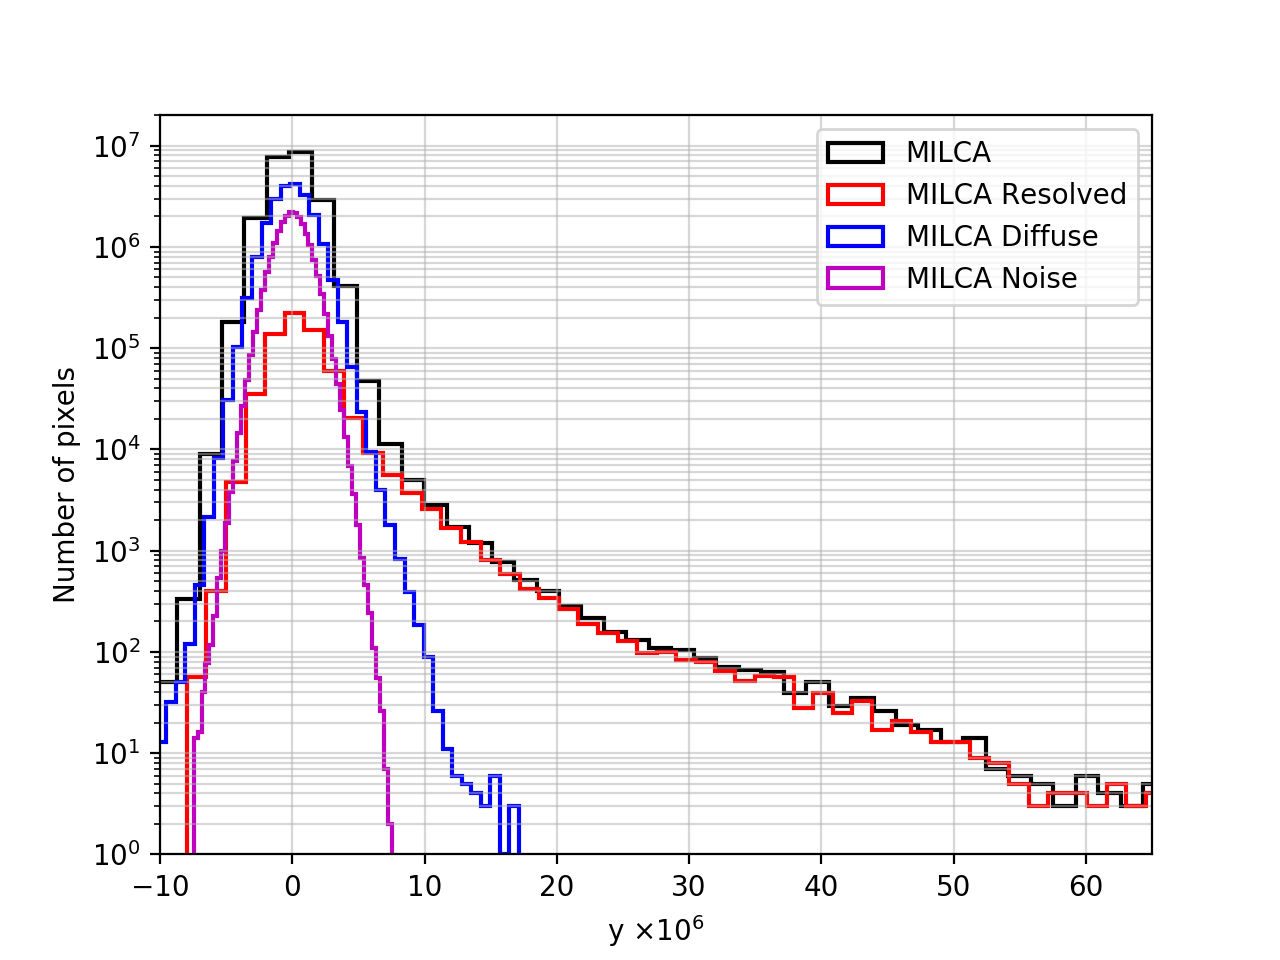

In [30]:
figure()
a,b,c=hist(nilc[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="Total",lw=1.5,color="k")
a,b,c=hist(((nilc_f-nilc_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="Noise",lw=1.5,color="m")
a,b,c=hist(nilc[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="uRC",lw=1.5,color="b")
a,b,c=hist(nilc[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="RC",lw=1.5,color="r")
semilogy()
legend(loc=0)
ylim(3,1e7)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_nilc_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

figure()
a,b,c=hist(milca[mask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA",lw=1.5,color="k")
a,b,c=hist(milca[mask*(1-clmask)!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Resolved",lw=1.5,color="r")
a,b,c=hist(milca[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Diffuse",lw=1.5,color="b")
a,b,c=hist(((milca_f-milca_l)/2.)[mask*clmask!=0]*1e6,histtype="step",bins=50,normed=False,label="MILCA Noise",lw=1.5,color="m")
semilogy()
legend(loc=0)
ylim(1,2e7)
xlim(-10,65)
grid(alpha=0.5,which="both")
figname=figpath + "y_milca_histogram.pdf"
xlabel(r"y $\times 10^6$")
ylabel("Number of pixels")
savefig(figname,bbox_inches="tight")

# Generate map figures

<IPython.core.display.Javascript object>


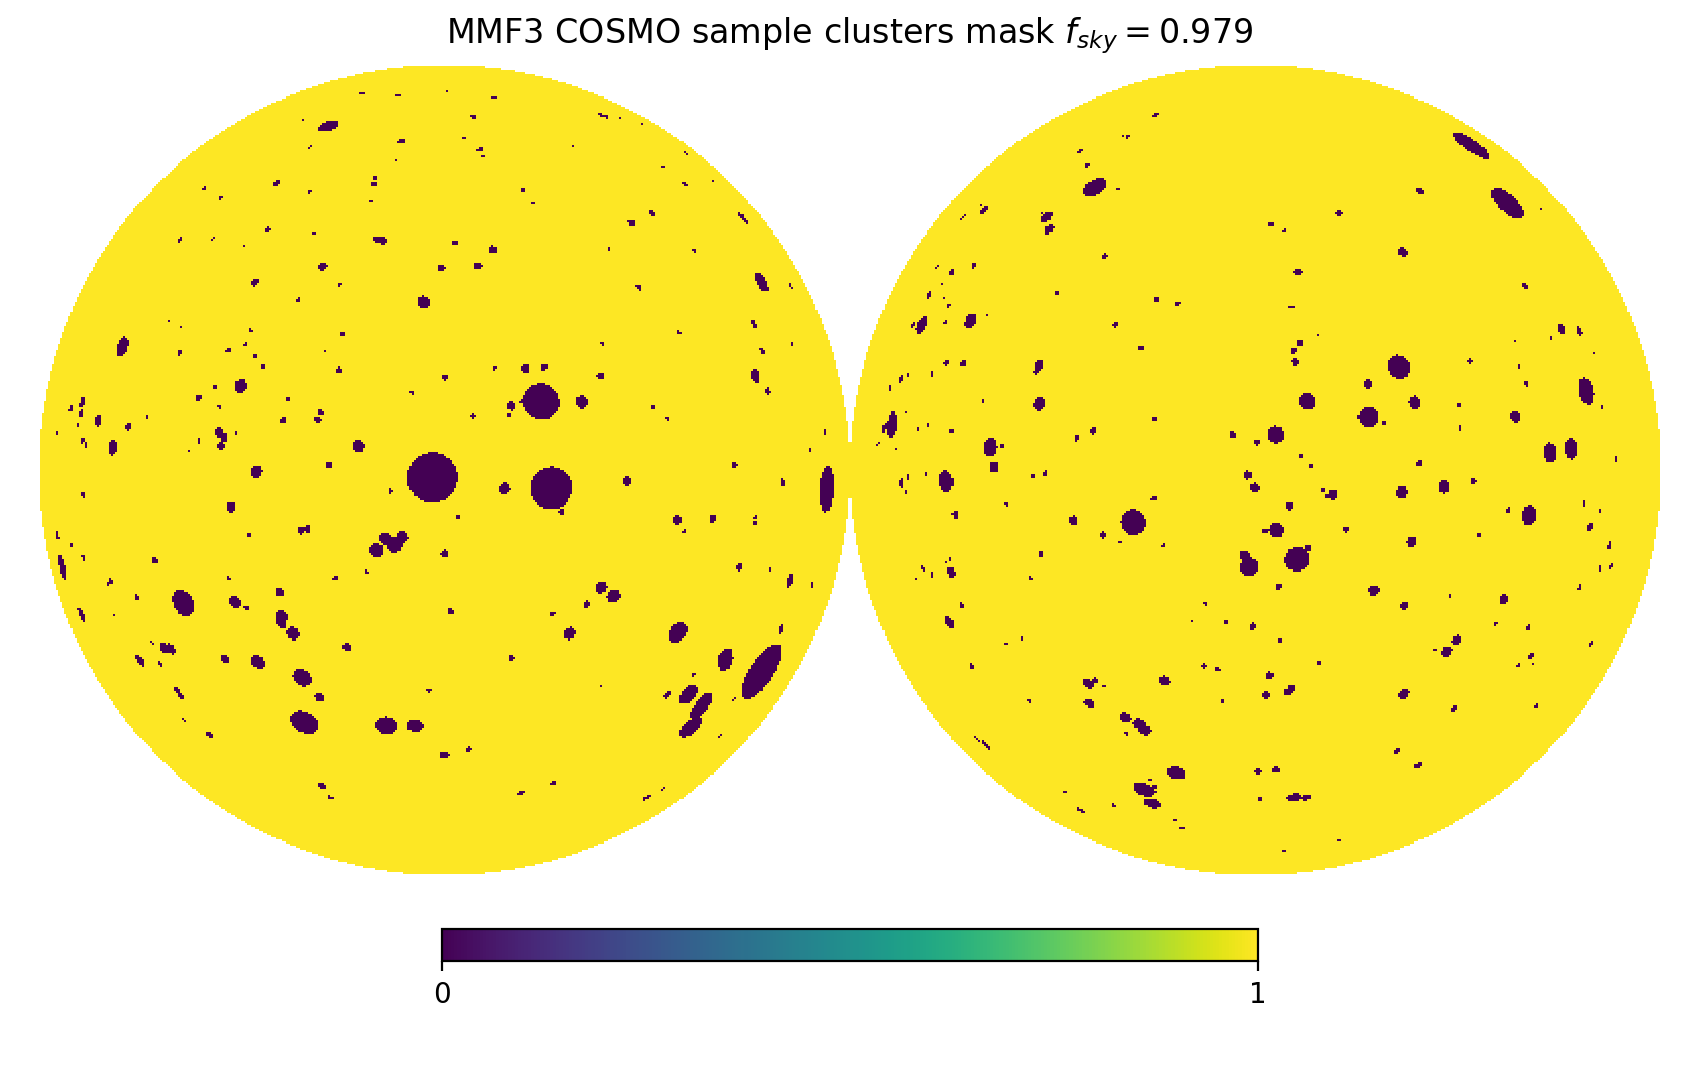

<IPython.core.display.Javascript object>


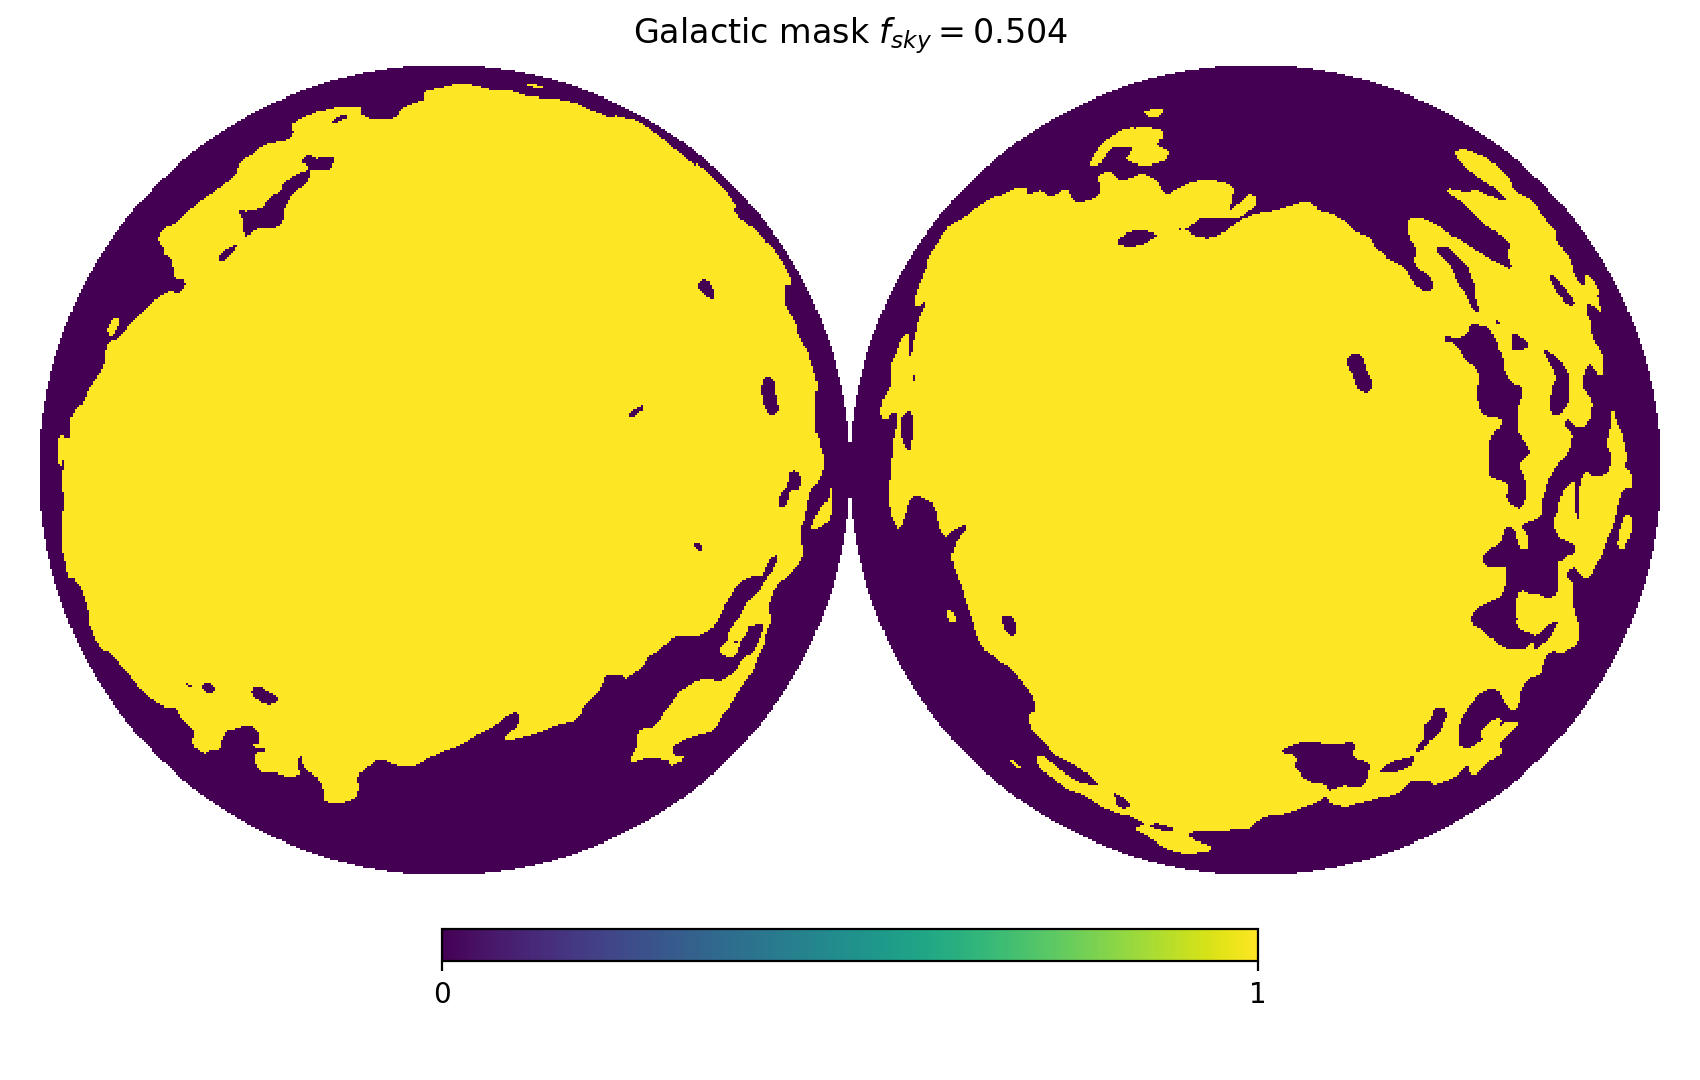

<IPython.core.display.Javascript object>


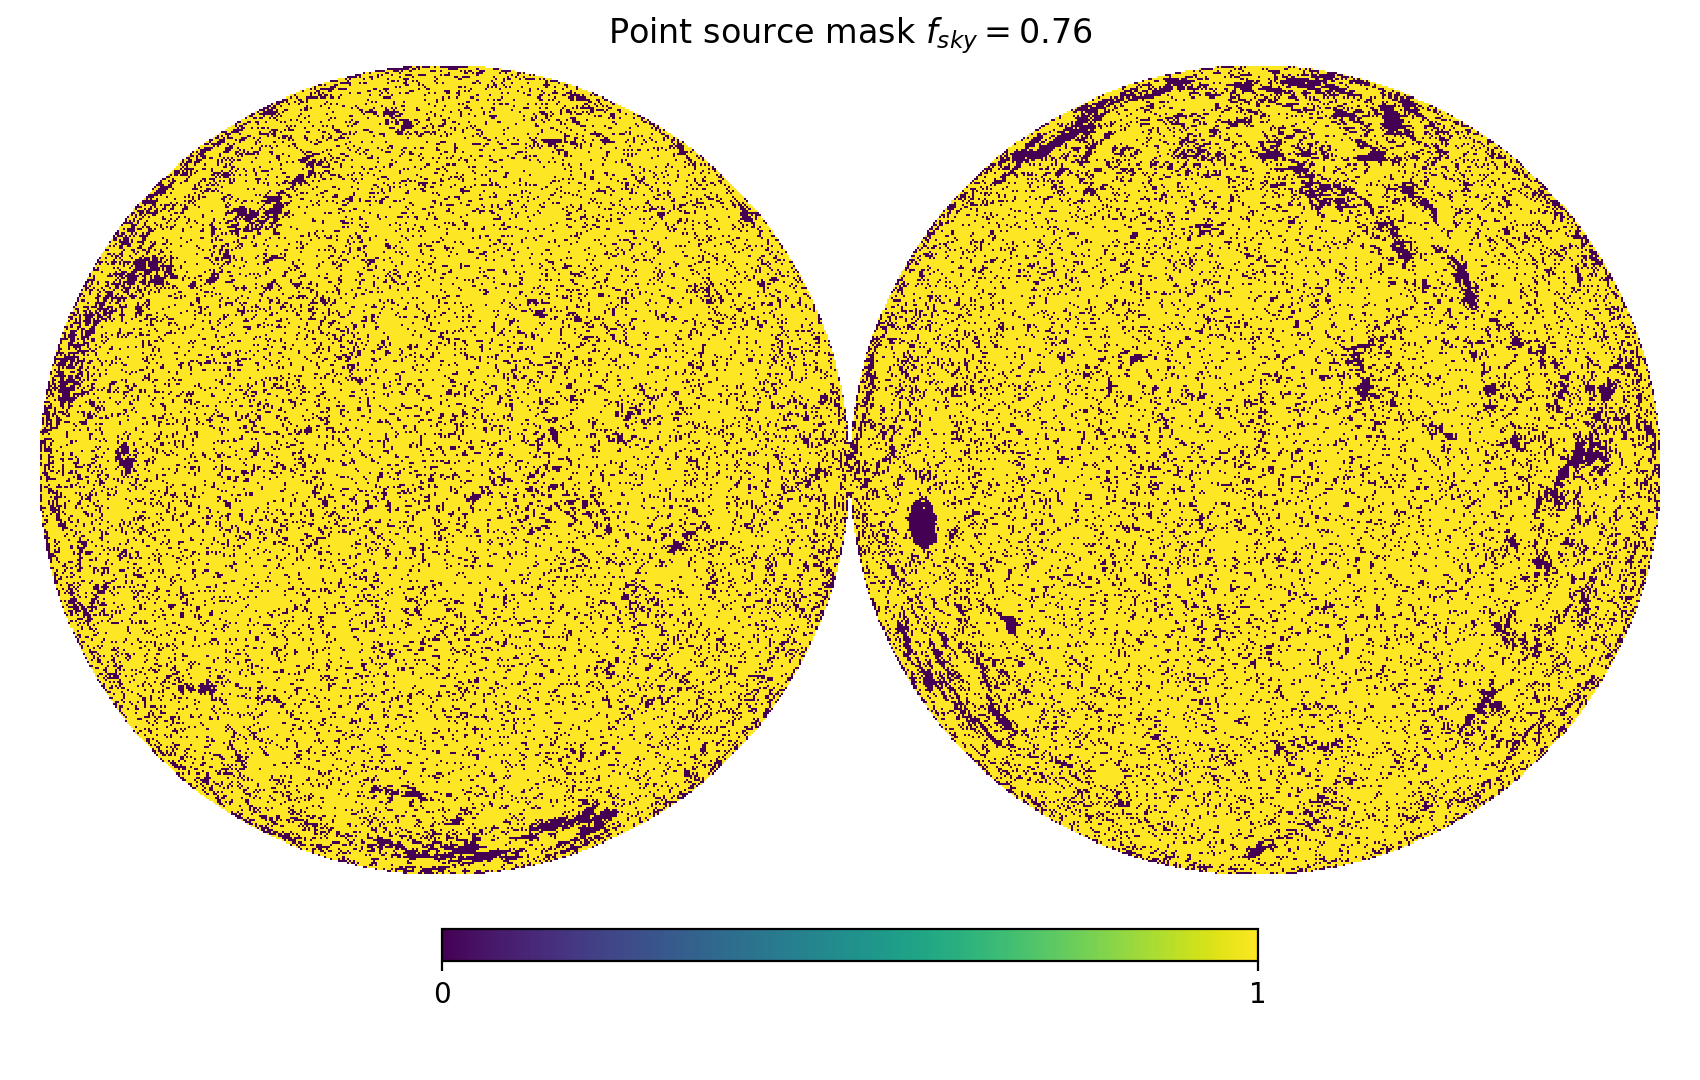

In [28]:
fsky=sum(clmask)/size(gmask)
h.orthview(clmask,rot=(0,90),title="MMF3 COSMO sample clusters mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(gmask)/size(gmask)
h.orthview(gmask,rot=(0,90),title="Galactic mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "gal_mask.pdf"
savefig(figname,bbox_inches="tight")

fsky=sum(psmask)/size(psmask)
h.orthview(psmask,rot=(0,90),title="Point source mask $f_{sky}=" + str(round(fsky,3)) + "$")
figname=figpath + "ps_mask.pdf"
savefig(figname,bbox_inches="tight")

# Power spectrum analysis

In [32]:
# Total
tmask=gal_ps_mask ; fsky_tot_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_tot=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_tot=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_tot=h.alm2cl(alm_milca,alm_milca)
#nilc_tot=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_tot=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
print "Total done"

# Diffuse
tmask=gal_ps_cl_mask ; fsky_diff_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_diff=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_diff=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_diff=h.alm2cl(alm_milca,alm_milca)
#nilc_diff=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_diff=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))
print "Diffuse done"

# Resolved
tmask=gal_ps_ccl_mask ; fsky_res_apo=sum(tmask)/size(tmask)
alm_milca=h.map2alm(milca_l*tmask,lmax=lmax) ; alm_nilc=h.map2alm(nilc_f*tmask,lmax=lmax)
nilc_milca_res=h.alm2cl(alm_nilc,alm_milca)
nilc_hm1_res=h.alm2cl(alm_nilc,alm_nilc)
milca_hm2_res=h.alm2cl(alm_milca,alm_milca)
print "Resolved done"
#nilc_res=h.alm2cl(h.map2alm(nilc_f*tmask,lmax=lmax),h.map2alm(nilc_l*tmask,lmax=lmax))
#milca_res=h.alm2cl(h.map2alm(milca_f*tmask,lmax=lmax),h.map2alm(milca_l*tmask,lmax=lmax))

Total done
Diffuse done
Resolved done


In [22]:
planckyy=np.loadtxt(datapath + "/maps/planck2015_yy_ps.txt")
bmin=planckyy[:,3]
bmax=planckyy[:,4]

# Data from Boris's papers
planck_yy=np.loadtxt(datapath + "/maps/bolliet2018.txt")

In [34]:
beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)*h.pixwin(nside)[:lmax+1]

mtot=bm.binned_master(gal_ps_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Total done"

mdiff=bm.binned_master(gal_ps_cl_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Diffuse done"

mres=bm.binned_master(gal_ps_ccl_mask,2,lmax,masklmax,beam=beam,bmin=bmin,bmax=bmax)
print "Resolved done"

Total done
Diffuse done
Resolved done


# CIB

In [86]:
fname=datapath + "/maps/COM_CompMap_CIB-GNILC-F353_2048_R2.00.fits"
cib353=h.read_map(fname,verbose=False)

alm_cib_tot=h.map2alm(cib353*gal_ps_mask,lmax=lmax)
alm_cib_res=h.map2alm(cib353*gal_ps_ccl_mask,lmax=lmax)
alm_cib_diff=h.map2alm(cib353*gal_ps_cl_mask,lmax=lmax)

In [88]:
cl_cib_tot=h.alm2cl(alm_cib_tot)
cl_cib_diff=h.alm2cl(alm_cib_diff)
cl_cib_res=h.alm2cl(alm_cib_res)

In [89]:
plnck_frg=np.loadtxt(datapath + "/maps/SZ_and_fg_models.txt")

In [92]:
figpath

'../../results/yy_spec//snr6_lmax1500_mlmax4096_apow30_lfpsT/figs/'

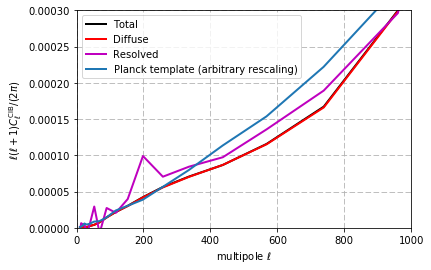

In [90]:
lbin,m_cib_tot=mtot.return_bmcs(cl_cib_tot)
lbin,m_cib_diff=mdiff.return_bmcs(cl_cib_diff)
lbin,m_cib_res=mres.return_bmcs(cl_cib_res)

figure()
plot(lbin,m_cib_tot,"k-",lw=2,label="Total")
plot(lbin,m_cib_diff,"r-",lw=2,label="Diffuse")
plot(lbin,m_cib_res,"m-",lw=2,label="Resolved")
plot(plnck_frg[:,0],plnck_frg[:,1]*2e-4,lw=2,label="Planck template (arbitrary rescaling)")
ylabel(r"$\ell(\ell+1)C_{\ell}^{\rm CIB} / (2 \pi)$")
xlabel(r"multipole $\ell$")
grid(which="both",linestyle="dashed")
xlim(0,1000)
ylim(0,0.0003)
legend(loc=0)
figname=figpath + "cib_spectrum_comparison.pdf"
savefig(figname,bbox_inches="tight")

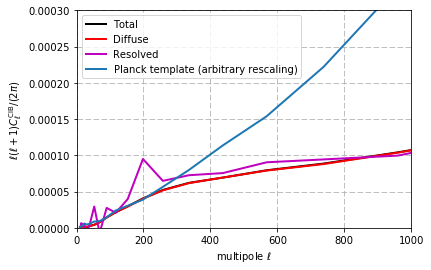

In [91]:
bl10=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)
bl5=h.gauss_beam(fwhm=(5./60.)*pi/180.,lmax=lmax)
bl=bl10/bl5
alm_cib_tot=h.almxfl(alm_cib_tot,fl=bl)
alm_cib_diff=h.almxfl(alm_cib_diff,fl=bl)
alm_cib_res=h.almxfl(alm_cib_res,fl=bl)

cl_cib_tot=h.alm2cl(alm_cib_tot)
cl_cib_diff=h.alm2cl(alm_cib_diff)
cl_cib_res=h.alm2cl(alm_cib_res)

lbin,m_cib_tot=mtot.return_bmcs(cl_cib_tot)
lbin,m_cib_diff=mdiff.return_bmcs(cl_cib_diff)
lbin,m_cib_res=mres.return_bmcs(cl_cib_res)

figure()
plot(lbin,m_cib_tot,"k-",lw=2,label="Total")
plot(lbin,m_cib_diff,"r-",lw=2,label="Diffuse")
plot(lbin,m_cib_res,"m-",lw=2,label="Resolved")
plot(plnck_frg[:,0],plnck_frg[:,1]*2e-4,lw=2,label="Planck template (arbitrary rescaling)")
ylabel(r"$\ell(\ell+1)C_{\ell}^{\rm CIB} / (2 \pi)$")
xlabel(r"multipole $\ell$")
grid(which="both",linestyle="dashed")
xlim(0,1000)
ylim(0,0.0003)
legend(loc=0)
figname=figpath + "cib_spectrum_comparison_with_deconvolution.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask

<IPython.core.display.Javascript object>


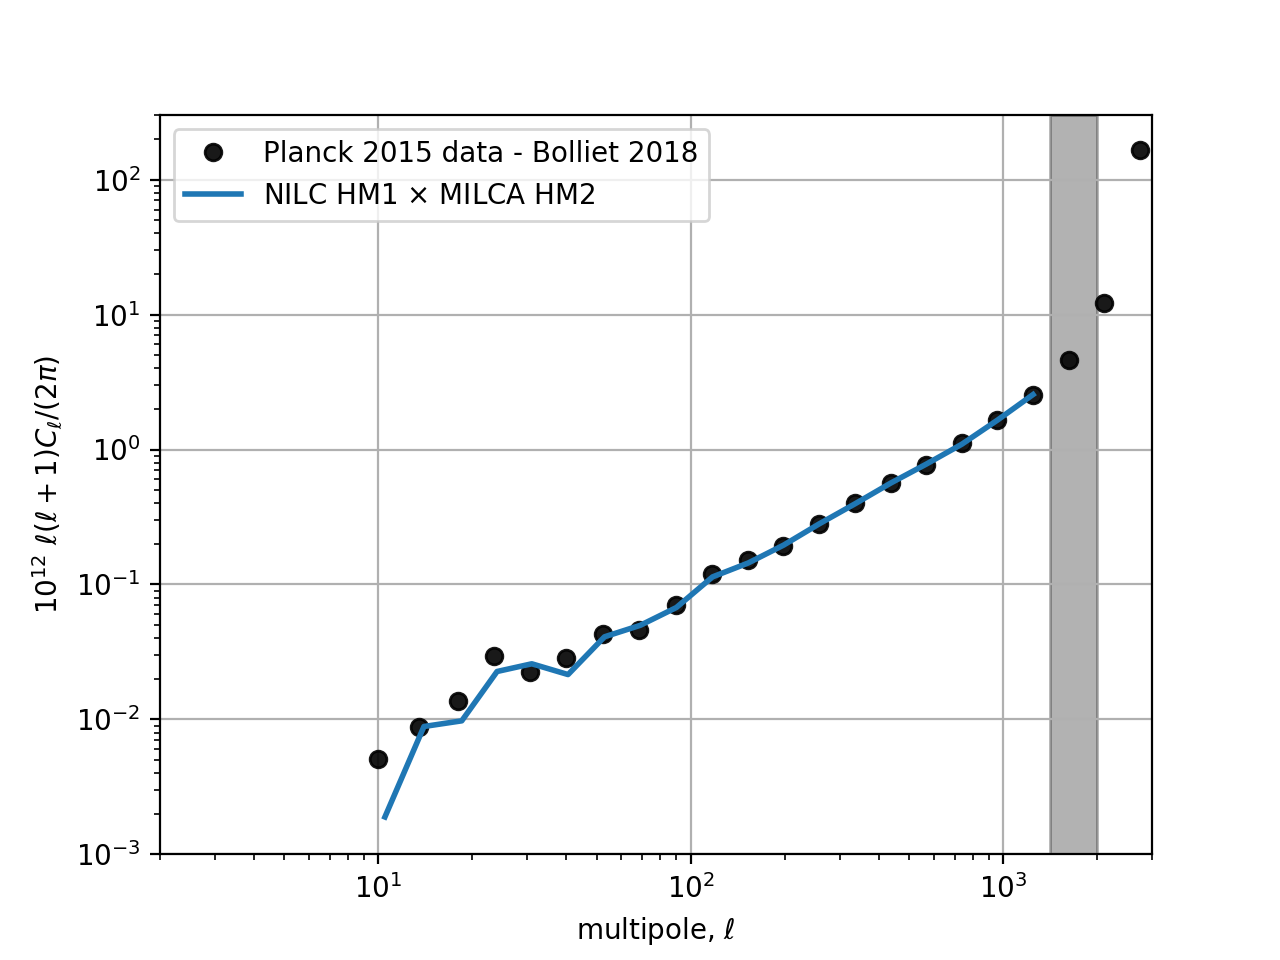

In [20]:
lbin,m_nilc_milca_tot=mtot.return_bmcs(nilc_milca_tot)
lbin,m_nilc_hm1_tot=mtot.return_bmcs(nilc_hm1_tot)
lbin,m_milca_hm2_tot=mtot.return_bmcs(milca_hm2_tot)
#lbin,m_nilc_tot=mtot.return_bmcs(nilc_tot)
#lbin,m_milca_tot=mtot.return_bmcs(milca_tot)


ell=arange(lmax+1)
bl=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=lmax)
pwc=h.pixwin(nside)[:lmax+1]
bl=bl*pwc
fl=ell*(ell+1)*1e12/(2.*pi)/bl/bl

figure()
plot(planck_yy[:,0],planck_yy[:,1],"ko",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.9,ms=6)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2")
#plot(lbin,m_nilc_tot*1e12,lw=2,label=r"NILC : HM1 $\times$ HM2")
#plot(lbin,m_milca_tot*1e12,lw=2,label=r"MILCA : HM1 $\times$ HM2")
#plot(d[:,0],d[:,2],"r-",lw=2,label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",lw=2,label="Planck 2015 data",alpha=0.7)


loglog()
legend(loc=0)
grid()
xlim(2,3e3)
ylim(1e-3,3e2)
#ylim(2e-4,4)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_gal_ps_mask.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask

<IPython.core.display.Javascript object>


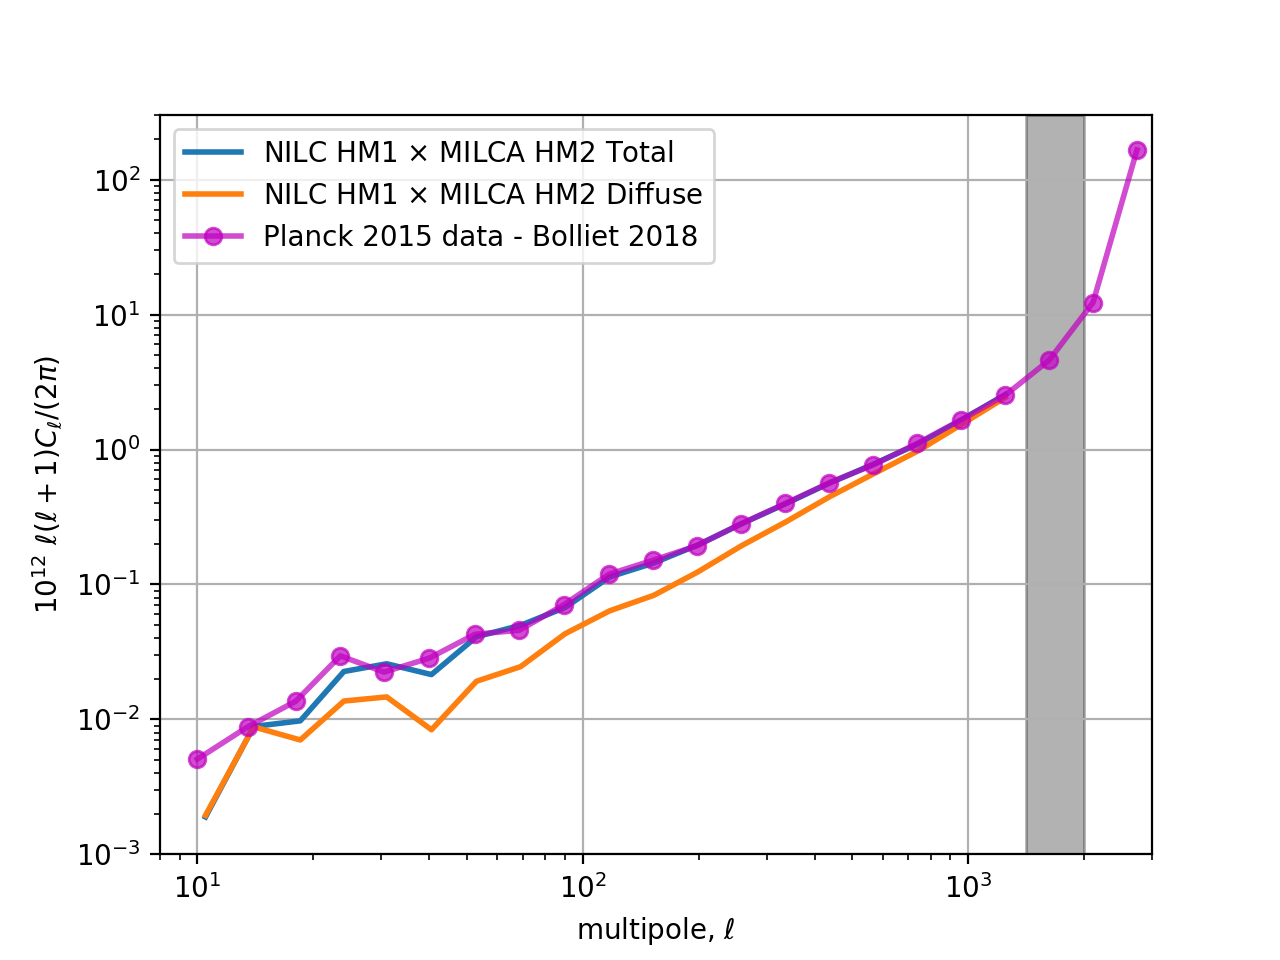

<IPython.core.display.Javascript object>


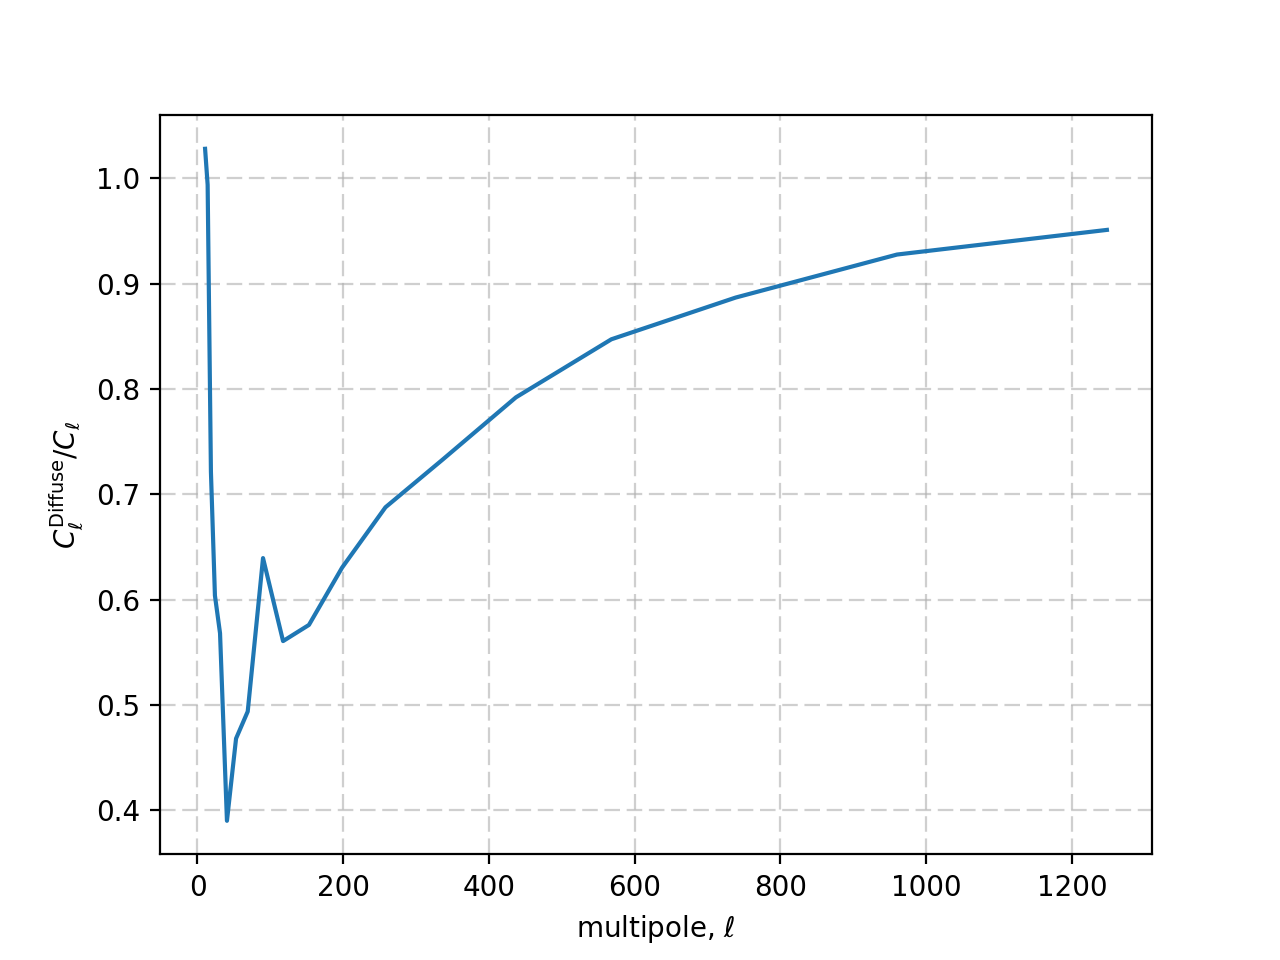

In [21]:
lbin,m_nilc_milca_diff=mdiff.return_bmcs(nilc_milca_diff)
lbin,m_nilc_hm1_diff=mdiff.return_bmcs(nilc_hm1_diff)
lbin,m_milca_hm2_diff=mdiff.return_bmcs(milca_hm2_diff)
#lbin,m_nilc_diff=mdiff.return_bmcs(nilc_diff)
#lbin,m_milca_diff=mdiff.return_bmcs(milca_diff)

figure()
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_diff*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Diffuse")
#plot(d[:,0],d[:,2],"r-",label="Planck 2015 best fit")
#plot(d[:,0],d[:,1],"k-o",label="Planck 2015 data",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
loglog()
legend(loc=0)
grid()
#xlim(8,3e3)
#ylim(4e-3,3e2)
xlim(8,3e3)
ylim(1e-3,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_diffuse_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm Diffuse}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_cldiffuse_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

## Galactic mask + point source mask + cluster mask complement

<IPython.core.display.Javascript object>


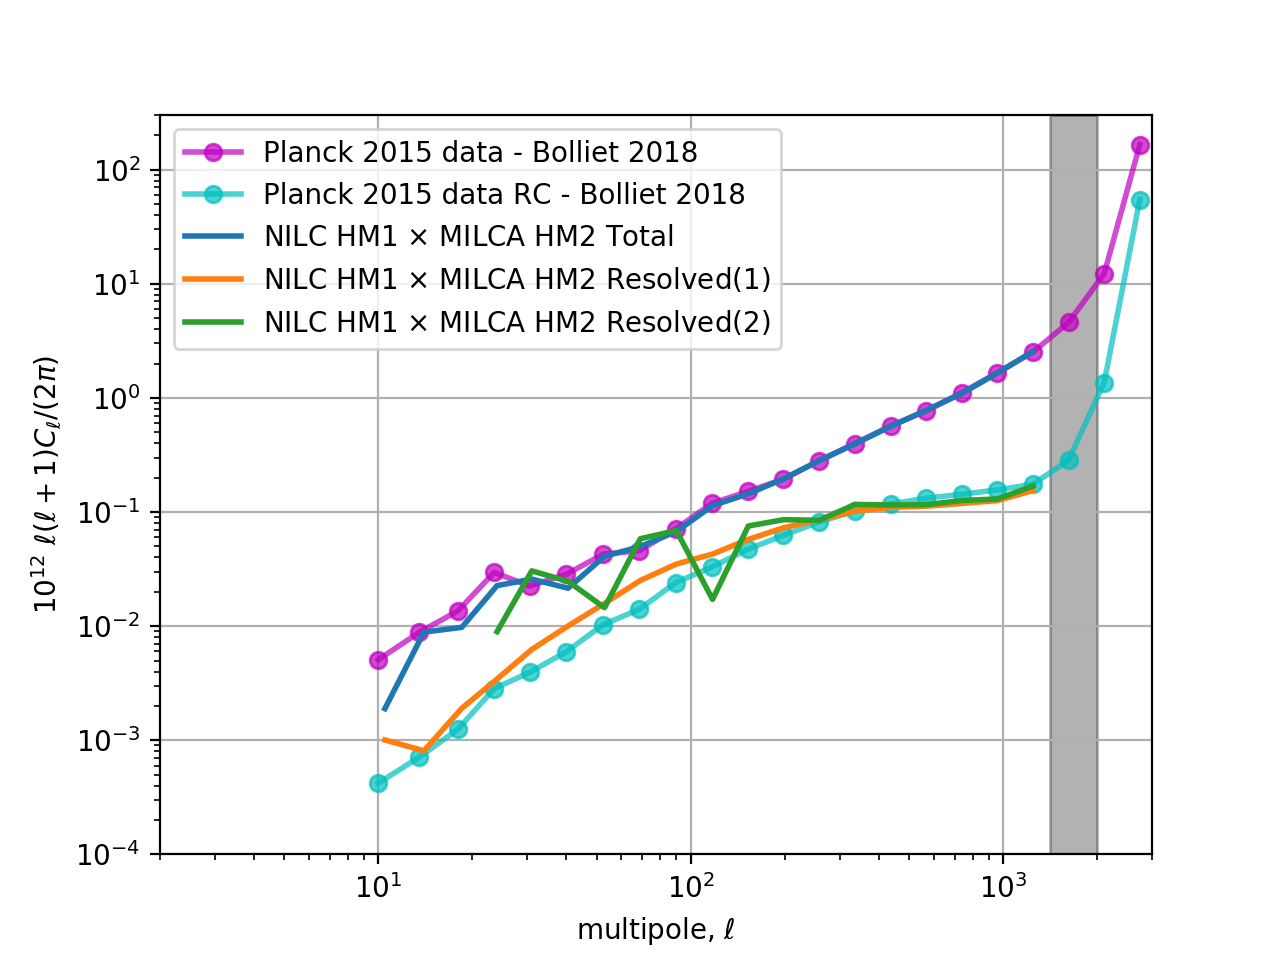

<IPython.core.display.Javascript object>


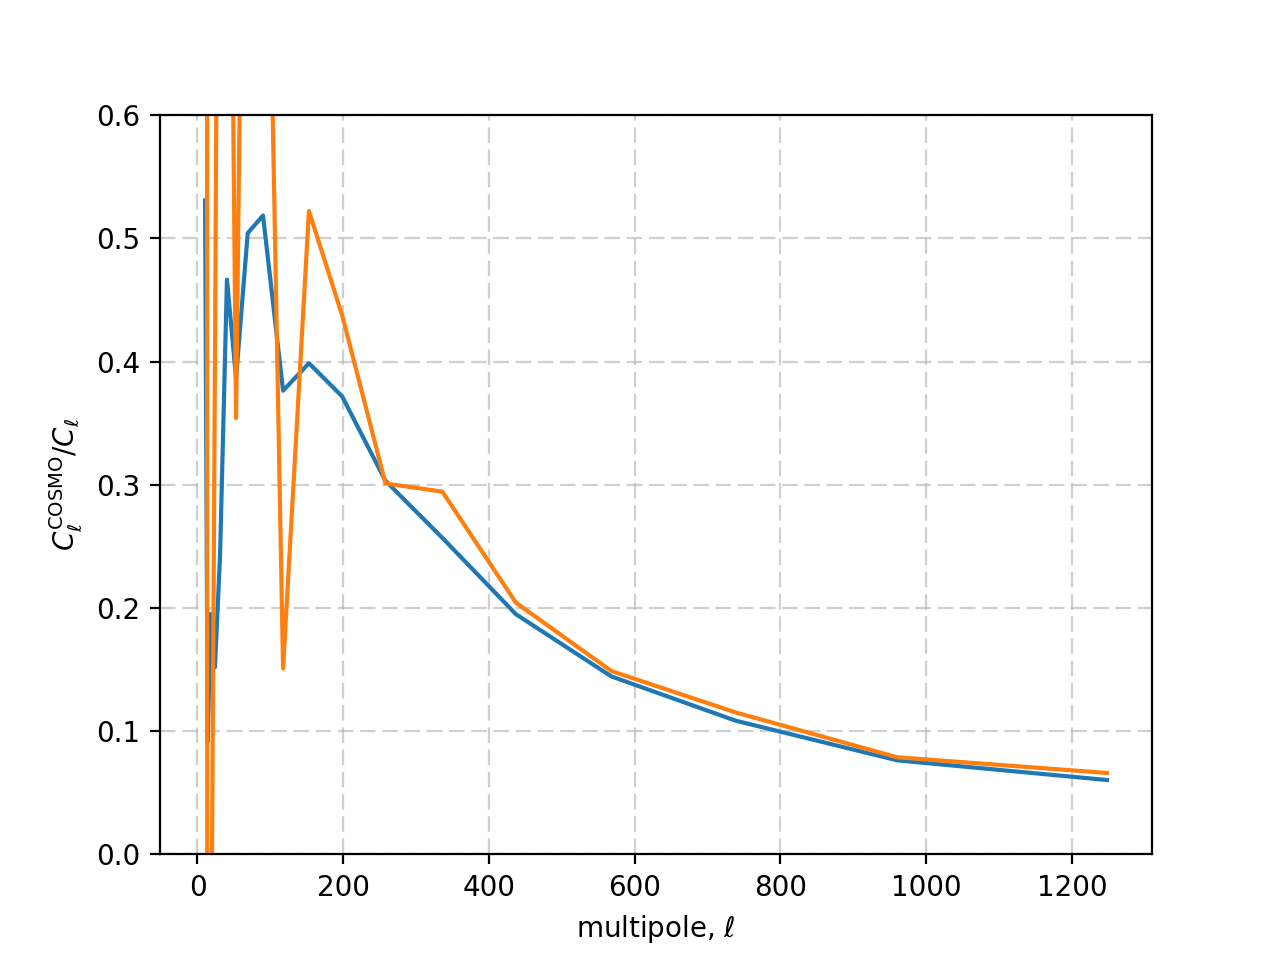

In [29]:
lbin,m_nilc_milca_res=mtot.return_bmcs(nilc_milca_res)
lbin,m_nilc_hm1_res=mtot.return_bmcs(nilc_hm1_res)
lbin,m_nilc_milca_res1=mres.return_bmcs(nilc_milca_res)
m_nilc_milca_res1=m_nilc_milca_res1*sum(gal_ps_ccl_mask)/sum(gal_ps_mask)
lbin,m_milca_hm2_res=mtot.return_bmcs(milca_hm2_res)
#lbin,m_nilc_res=mres.return_bmcs(nilc_res)
#lbin,m_milca_res=mres.return_bmcs(milca_res)


tmpell=arange(lmax+1)
figure()
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data - Bolliet 2018",alpha=0.7)
plot(planck_yy[:,0],planck_yy[:,3],"c-o",lw=2,label="Planck 2015 data RC - Bolliet 2018",alpha=0.7)
plot(lbin,m_nilc_milca_tot*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Total")
plot(lbin,m_nilc_milca_res*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Resolved(1)")
plot(lbin,m_nilc_milca_res1*1e12,lw=2,label=r"NILC HM1 $\times$ MILCA HM2 Resolved(2)")
# plot(lbin,m_milca_hm2_res*1e12)
# plot(lbin,m_nilc_hm1_res*1e12)
#plot(tmpell,tmpell*(tmpell+1.)*nilc_milca_res*1e12/(2.*pi*fsky_tot*beam*beam))
loglog()
legend(loc=0)
grid()
#semilogx()
xlim(2,3e3)
#ylim(1e-4,50)
ylim(1e-4,3e2)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare_cosmo_vs_total.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot)
plot(lbin,m_nilc_milca_res1/m_nilc_milca_tot)
xlabel(r"multipole, $\ell$")
ylabel(r"$C^{\rm COSMO}_{\ell}/C_{\ell}$")
grid(alpha=0.6,linestyle="dashed")
ylim(0,0.6)

figname=figpath + "ratio_clresolved_by_cltotal.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


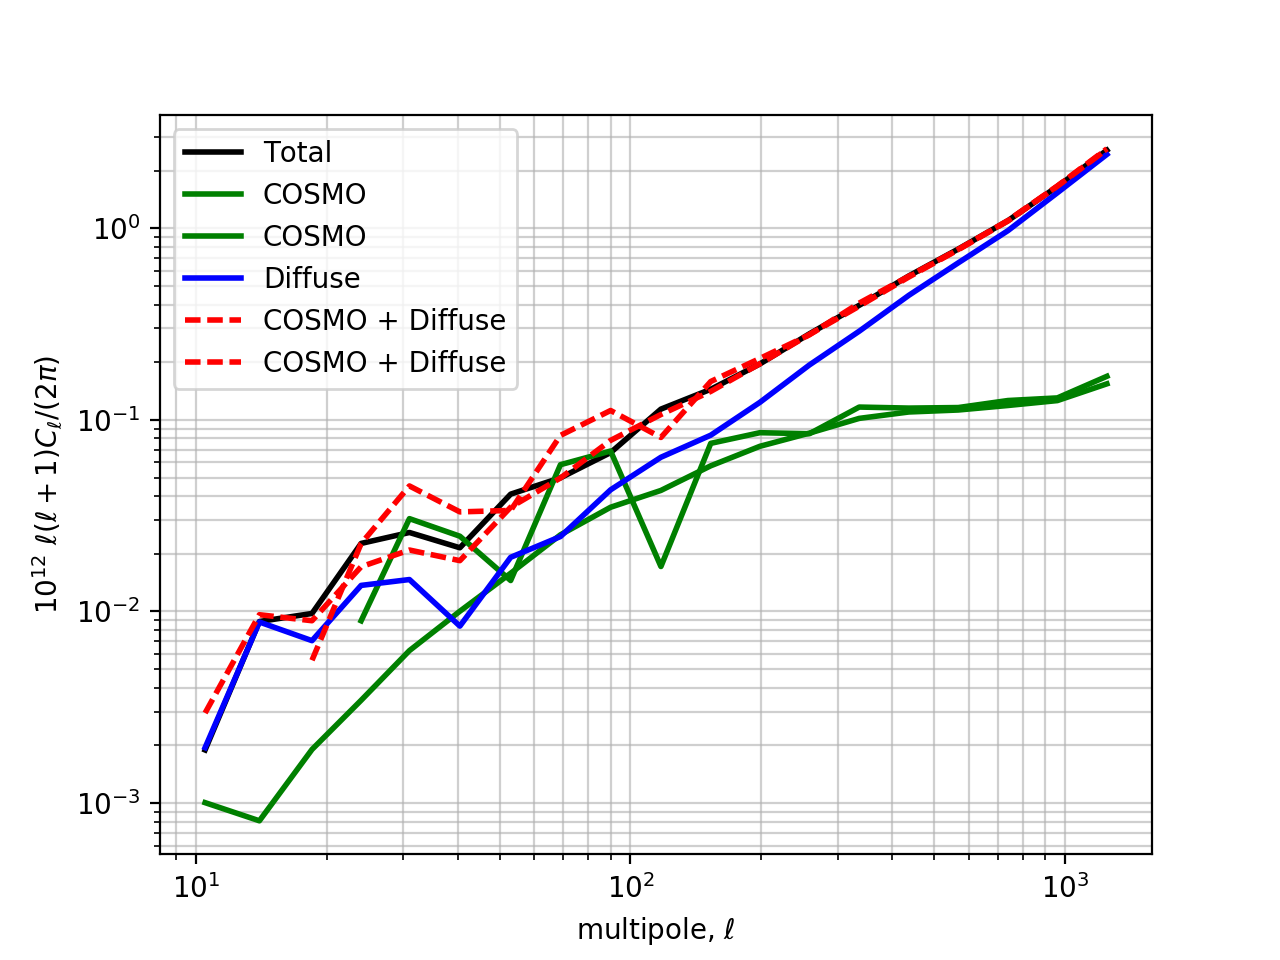

<IPython.core.display.Javascript object>


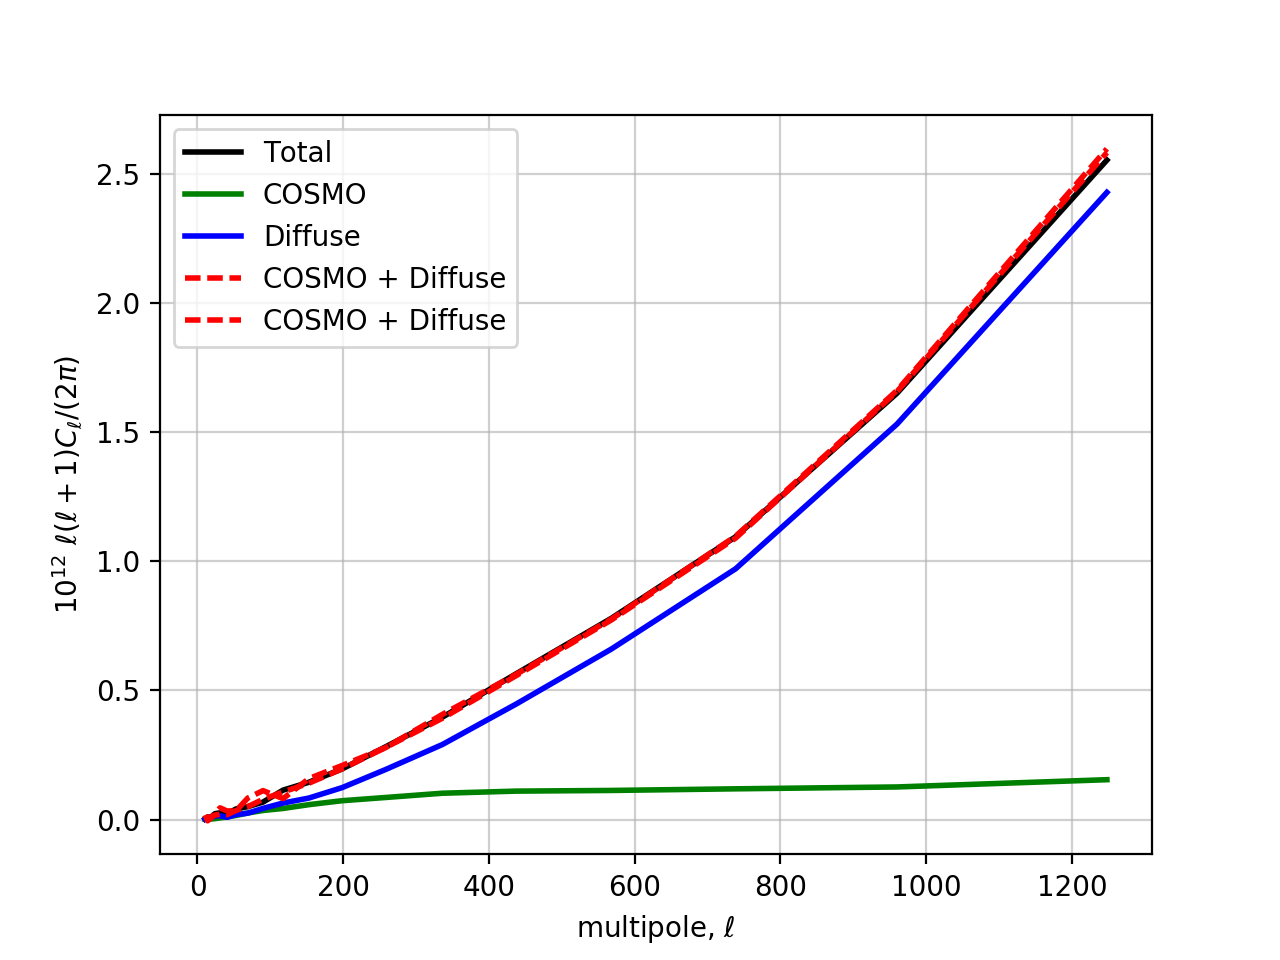

In [32]:
figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_res1*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
plot(lbin,(m_nilc_milca_res1+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
loglog()
figname=figpath + "test_spectra_additive.pdf"
savefig(figname,bbox_inches="tight")

figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_res*1e12,"g-",lw=2,label=r"COSMO")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"Diffuse")
plot(lbin,(m_nilc_milca_res+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
plot(lbin,(m_nilc_milca_res1+m_nilc_milca_diff)*1e12,"r--",lw=2,label=r"COSMO + Diffuse")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
grid(which="both",alpha=0.6,linestyle="solid")
legend(loc=0)
#semilogx()
#ylim(0,0.05)
figname=figpath + "test_spectra_additive_linear.pdf"
savefig(figname,bbox_inches="tight")

In [ ]:
figure()
plot(lbin,m_nilc_milca_diff/m_nilc_milca_tot,"b.-",lw=2,label=r"$C^{\rm uRC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,m_nilc_milca_res/m_nilc_milca_tot,"r.-",lw=2,label=r"$C^{\rm RC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,m_nilc_milca_res1/m_nilc_milca_tot,"r--",lw=2,label=r"$C^{\rm RC}_{\ell}/C^{\rm Total}_{\ell}$")
plot(lbin,(m_nilc_milca_diff + m_nilc_milca_res)/m_nilc_milca_tot,"k.-",lw=2,label=r"$(C^{\rm RC}_{\ell} + C^{\rm uRC}_{\ell})/C^{\rm Total}_{\ell}$")
axhline(1.,ls="dashed",c="k")
xlabel(r"multipole, $\ell$")
ylabel("Ratio of yy-power spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
figname=figpath + "ratio_of_power_in_y.pdf"
semilogx()
savefig(figname,bbox_inches="tight")

In [ ]:
tmpell=arange(lmax+1)
figure()
plot(lbin,m_nilc_milca_tot*1e12,"k-",lw=2,label=r"Total")
plot(lbin,m_nilc_milca_diff*1e12,"b-",lw=2,label=r"uRC")
plot(lbin,m_nilc_milca_res*1e12,"r-",lw=2,label=r"RC")
plot(planck_yy[:,0],planck_yy[:,1],"m-o",lw=2,label="Planck 2015 data",alpha=0.5)
plot(planck_yy[:,0],planck_yy[:,3],"c-o",lw=2,label="Planck 2015 data RC (simulated)",alpha=0.5)
#plot(lbin,m_nilc_milca_diff*1e12 + m_nilc_milca_res*1e12,"r--",lw=2,label=r"uRC + RC")

loglog()
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.6)
#semilogx()
xlim(9,2e3)
#ylim(1e-4,50)
ylim(2e-4,2e1)
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlabel("multipole, $\ell$")
axvspan(1411,2000,color="k",alpha=0.3)
figname=figpath + "yy_power_spectrum_compare.pdf"
savefig(figname,bbox_inches="tight")

# Error estimation

In [ ]:
err_tot=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
err_tot=1e12*np.sqrt(err_tot*(m_milca_hm2_tot*m_nilc_hm1_tot + m_nilc_milca_tot**2.))

# err=(1./((2.*lbin+1.)*mtot.deltaell_bin*fsky_tot_apo))
# err=1e12*np.sqrt(err*(2.*m_nilc_milca_tot**2.))

err_diff=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_diff_apo))
err_diff=1e12*np.sqrt(err_diff*(m_milca_hm2_diff*m_nilc_hm1_diff + m_nilc_milca_diff**2.))

err_res=(1./((2.*lbin+1.)*mdiff.deltaell_bin*fsky_tot_apo))
err_res=1e12*np.sqrt(err_res*(m_milca_hm2_res*m_nilc_hm1_res + m_nilc_milca_res**2.))

figure()

plot(lbin,err_tot,"k-",lw=2,label="Total")
plot(lbin,err_diff,"b-",lw=2,label="uRC")
plot(lbin,err_res,"r-",lw=2,label="RC")
#plot(lbin,err,lw=2,label="Signal CV")
#plot(lbin,m_nilc_milca_tot*1e12,lw=2,label="Signal")
#plot(lbin,np.sqrt(err_res**2. + err_diff**2.),lw=2,label="Diffuse + Resolved (added in quadrature)")
plot(planck_yy[:,0],planck_yy[:,2],"m--",lw=2,label="Planck 2015 data",alpha=0.6)
plot(planck_yy[:19,0],planck_yy[:19,2]-err_tot,"g--",label="|Planck 2015 data - Total|")
xlabel(r"multipole, $\ell$")
ylabel(r"$10^{12}$" + r" $\ell(\ell+1)\sigma_{C_{\ell}}/(2 \pi)$")
grid(alpha=0.6,linestyle="dashed",which="both")
loglog()
ylim(1e-4,5e-1)
xlim(9,2e3)
#ylim(2e-4,2e1)
legend(loc=0,fontsize=9)
figname=figpath + "error_estimates.pdf"
savefig(figname,bbox_inches="tight")

# Write data

In [ ]:
filename=dataout_path + "total_yy_spec.txt"
title_str="# Total yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: SNR>=0. & COSMO=F ")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin","lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_tot[i]*1e12,err_tot[i]))
f.close()
tot=loadtxt(filename)

filename=dataout_path + "unresolved_yy_spec.txt"
title_str="# Un-resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_diff,3)) + " ; effective_fsky=" + str(round(fsky_diff_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: COMPLEMENT(SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_diff[i]*1e12,err_diff[i]))
f.close()
diff=loadtxt(filename)

filename=dataout_path + "resolved_yy_spec.txt"
title_str="# Resolved yy-spectrum"
fsky_str="# fsky=" + str(round(fsky_tot,3)) + " ; effective_fsky=" + str(round(fsky_tot_apo,3))
f=open(filename,"wb")
f.write("%-s \n" % title_str)
f.write("%-s \n" % "# Flags: (SNR>=6. & COSMO=T)")
f.write("%-s \n \n" % fsky_str)
f.write("%-15s %-15s %-15s %-15s %-15s \n \n" % ("# lmin", "lmax", "ell_eff","Dlyy*1e12","err_Dlyy*1e12 (Gauss)"))
for i in range(np.size(lbin)):
    f.write("%-15.8f %-15.8f %-15.8f %-15.8f %-15.8f\n" % (mtot.bmin[i],mtot.bmax[i],lbin[i],m_nilc_milca_res[i]*1e12,err_res[i]))
f.close()
res=loadtxt(filename)

In [ ]:
figure()
plot(lbin,res[:,3])
plot(lbin,m_nilc_milca_res*1e12,"--")

figure()
plot(lbin,diff[:,4])
plot(lbin,err_diff,"--")
loglog()

# Test master algorithm

<IPython.core.display.Javascript object>


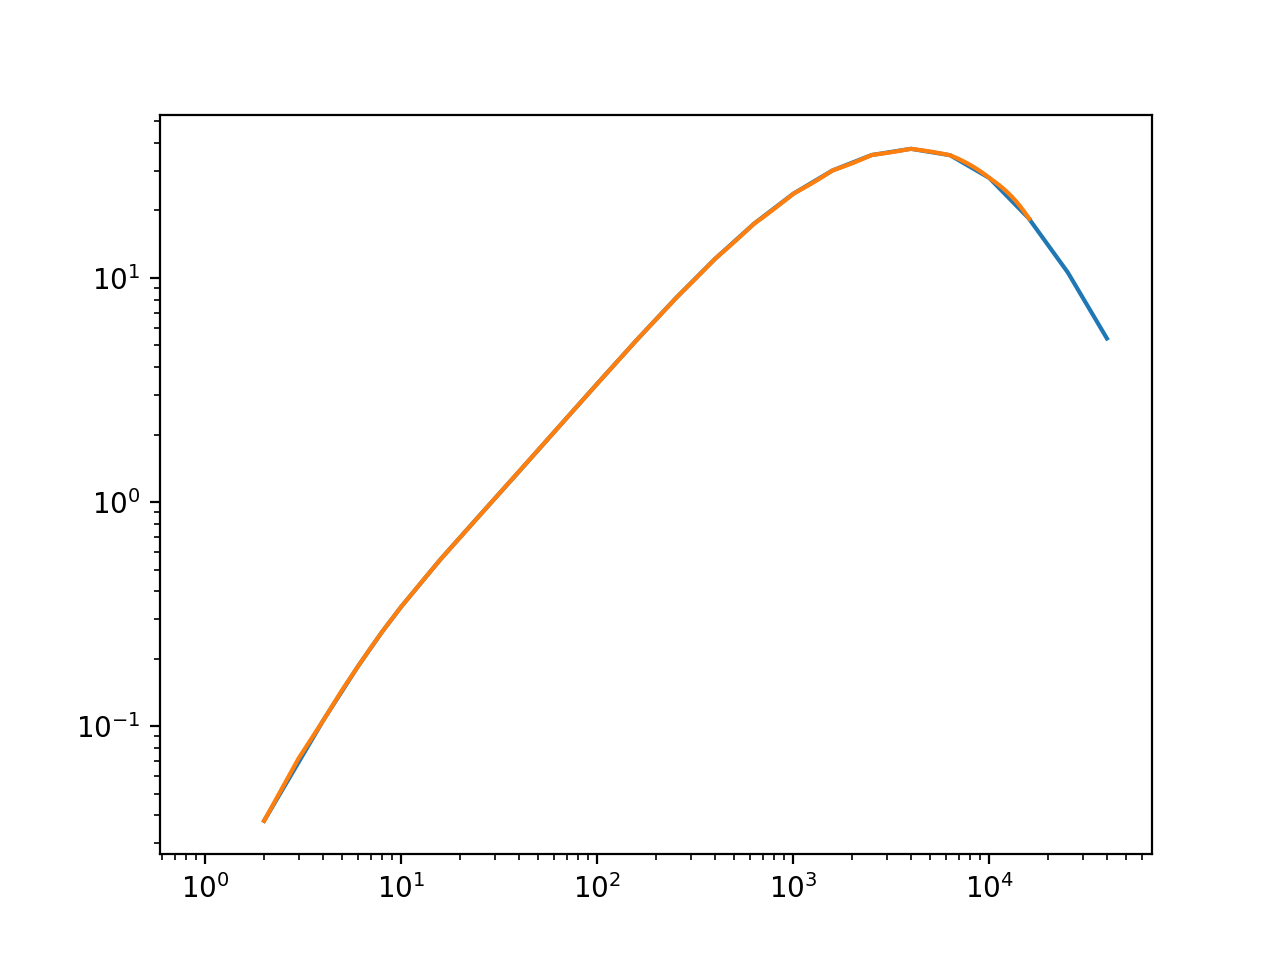

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [22]:
from scipy.interpolate import interp1d
d=loadtxt(datapath + "/spectra/multipole_szpower_1e11_5e16.txt")
fn=interp1d(d[:,0],d[:,1])
ell=arange(15999,dtype="float") ; ell=ell+2.
clyy=fn(ell)
clyy=clyy*2.*pi/(ell*(ell+1.))
clyy=append(np.zeros(2,float),clyy)
ell=append(arange(2,dtype="float"),ell)

figure()
plot(d[:,0],d[:,1])
plot(ell,ell*(ell+1)*clyy/(2.*pi))
loglog()

beam=h.gauss_beam(fwhm=(10./60.)*pi/180.,lmax=2000)*h.pixwin(nside)[:2001]
alm=h.synalm(clyy,lmax=2000,new=True) ; alm=h.almxfl(alm,beam)
sim_map=h.alm2map(alm,nside)

In [20]:
tmask=gal_ps_ccl_mask ; fsky_res=sum(tmask)/size(tmask)
simcl_res=h.alm2cl(h.map2alm(sim_map*tmask,lmax=lmax))
lbin,m_simcl_res=mres.return_bmcs(simcl_res)

tmask=gal_ps_cl_mask ; fsky_diff=sum(tmask)/size(tmask)
simcl_diff=h.alm2cl(h.map2alm(sim_map*tmask,lmax=lmax))
lbin,m_simcl_diff=mdiff.return_bmcs(simcl_diff)

In [ ]:
h.orthview(sim_map*gal_ps_ccl_mask ,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky_res,3)) + ")$")
figname=figpath + "sim_masked_y_res.pdf"
savefig(figname,bbox_inches="tight")

h.orthview(sim_map*gal_ps_cl_mask ,rot=(0,90),min=-5,max=5,title=r"Simulated y-map $(f_{\rm sky}=" + str(round(fsky_diff,3)) + ")$")
figname=figpath + "sim_masked_y_diff.pdf"
savefig(figname,bbox_inches="tight")

ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*simcl_res[:lmax+1]/(2.*pi*fsky_res*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*clyy[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,m_simcl_res,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(4e-3,35)
semilogx()
#loglog()
figname=figpath + "sim_cl_yy_res.pdf"
loglog()
savefig(figname,bbox_inches="tight")

ell=arange(lmax+1)
figure()
plot(ell,ell*(ell+1)*simcl_diff[:lmax+1]/(2.*pi*fsky_diff*bl[:lmax+1]*bl[:lmax+1]),alpha=0.8,label=r"$f_{sky}$ corrected spectrum")
plot(ell,ell*(ell+1)*clyy[:lmax+1]/(2.*pi),"k-",lw=2,label="True spectrum")
plot(lbin,m_simcl_diff,"r-.",label="Master corrected spectrum")
legend(loc=0)
grid(alpha=0.6,linestyle="dashed")
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C_{\ell}/(2 \pi)$")
xlim(8,1500)
ylim(4e-3,35)
semilogx()
#loglog()
figname=figpath + "sim_cl_yy_diff.pdf"
loglog()
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mres.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
figname=figpath + "coupling_matrix_resolved_cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

figure()
imshow(log10(mdiff.mbbp),origin="lower")
xlabel("multipole, $\ell$")
ylabel("multipole, $\ell'$")
colorbar()
xticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
yticks(linspace(0,size(lbin)-1,5),linspace(2,lmax,5))
figname=figpath + "coupling_matrix_diffuse_cluster_mask.pdf"
savefig(figname,bbox_inches="tight")

# Theory

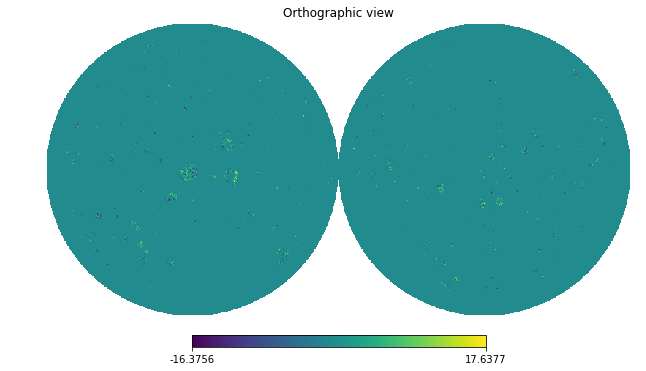

In [54]:
# h.orthview(gal_ps_ccl_mask*tmap,rot=(0,90))

In [188]:
# dtot=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_1e11_5e15.txt")
# dhm=loadtxt("../../../../Paper_plots/relativistic_sz/clyy/multipole_szpower_5e14_5e15.txt")

<IPython.core.display.Javascript object>


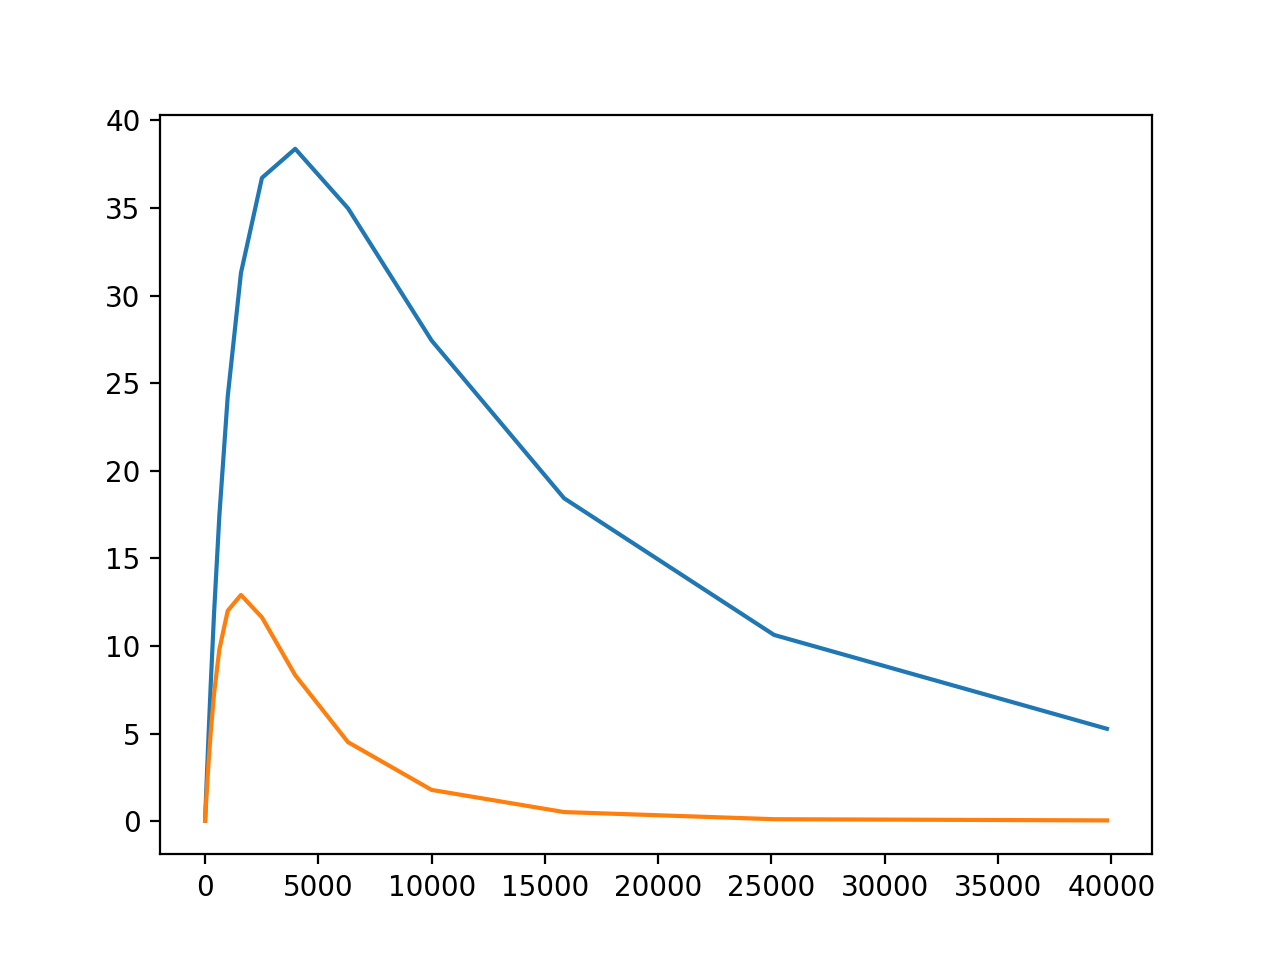

<IPython.core.display.Javascript object>


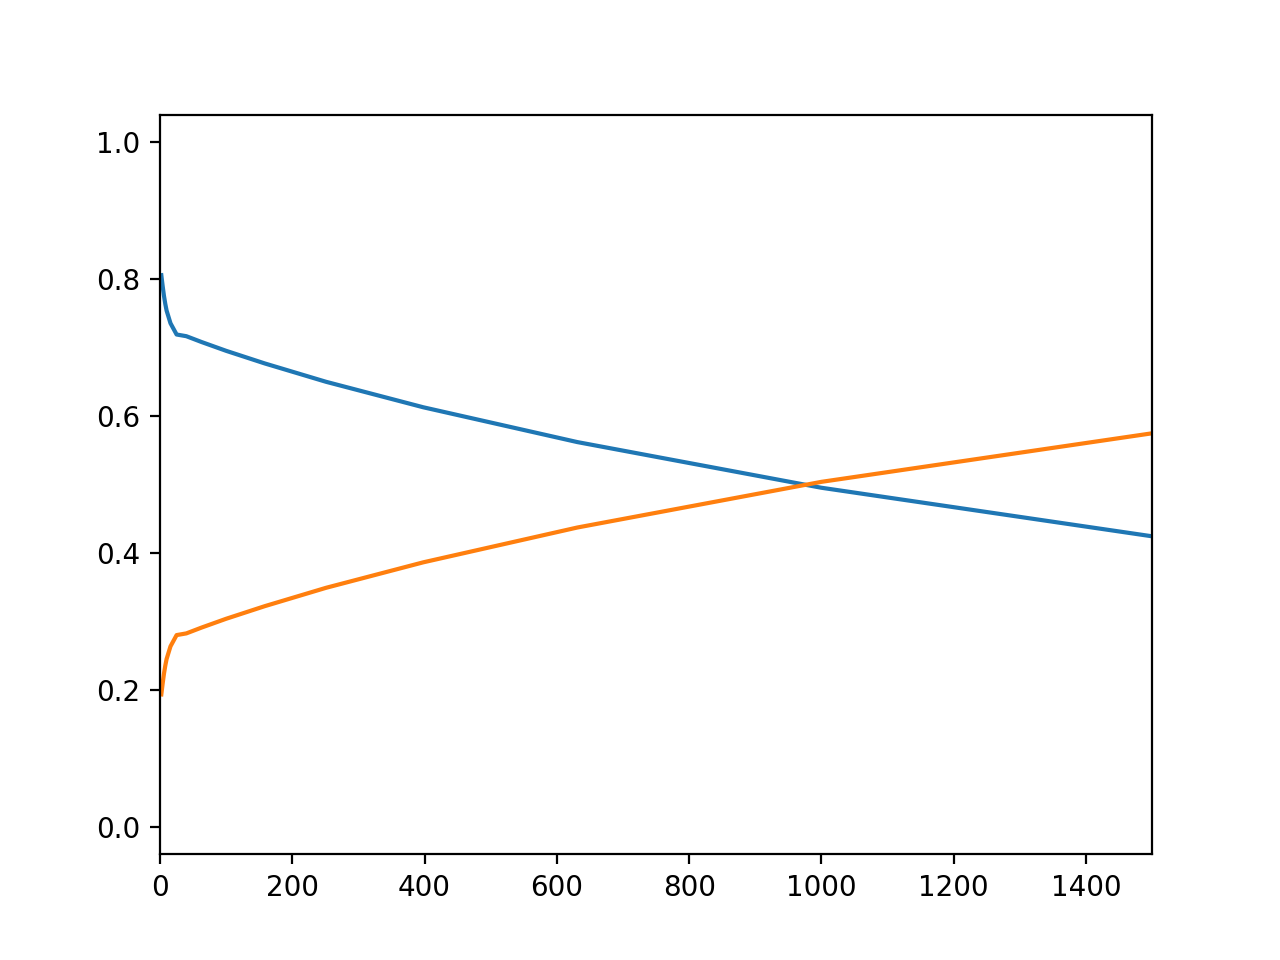

(0, 1500)

In [194]:
# figure()
# plot(dtot[:,0],dtot[:,1])
# plot(dhm[:,0],dhm[:,1])

# figure()
# plot(dhm[:,0],dhm[:,1]/dtot[:,1])
# plot(dhm[:,0],(dtot[:,1]-dhm[:,1])/dtot[:,1])
# xlim(0,1500)